# Netflix Data Analysis

## Business Problem & Objectives
**Primary Goal:** Transform 25 million user ratings into actionable content strategy insights to optimize movie recommendations and catalog management.

**Key Business Questions:**
- Which genres and decades demonstrate the highest user engagement and ratings?
- How effectively does the genome algorithm identify successful movie traits?
- Where are the biggest gaps in our content tagging and metadata coverage?
- What patterns emerge between movie popularity, quality, and characteristics?

## End-to-End Data Pipeline
This analysis is the final stage of a comprehensive data pipeline:

1. **Data Ingestion** (`netflix_ingestion.py`)  
   → Automated CSV to PostgreSQL loading with chunked processing

2. **Data Exploration** (`Netflix_Movie_Analysis.sql`)  
   → SQL-based data understanding and business rule development

3. **Data Cleaning** (`get_movie_summary.py`)  
   → Python implementation of validated business rules and feature engineering

4. **Analysis & Insights** (This Notebook)  
   → Python-based statistical exploration and pattern identification

5. **Business Intelligence** (`Netflix Dashboard.twbx`)  
   → Interactive visualizations for content strategy decision-making

## Expected Outcomes
- Data-driven content acquisition and tagging priorities
- Genome algorithm performance validation and improvement areas
- Genre and decade-based user preference mapping
- Foundation for enhanced recommendation systems

---
*Note: Detailed methodology and business logic development documented in SQL exploration files.*

In [1]:
# Core data wrangling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics (tests, distributions, CIs)
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests  # Benjamini–Hochberg FDR

# Sql & Utilities
import warnings
import psycopg2  
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')

In [2]:
# Visual style and pandas display
sns.set_theme(context="notebook", style="whitegrid")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 120)
pd.set_option("display.precision", 2)

In [3]:
# PostgreSQL Connection Setup 
# Database configuration - REPLACE WITH YOUR CREDENTIALS
DB_USER = "your_postgres_username"
DB_PASS = "your_postgres_password" 
DB_HOST = "localhost"
DB_PORT = "5433"
DB_NAME = "vendor_db" 

# Create SQLAlchemy engine for pandas
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# For direct SQL queries (if needed)
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASS,
    port=DB_PORT
)

In [4]:
df= pd.read_sql_query("SELECT * FROM summary_table", conn)
df.head(10)

,movieId,title,year,genre,avg_rating,rating_count,top_genome_tag,genome_relevance,most_common_user_tag
0,1,Toy Story (1995),1995,Adventure,3.89,57309,toys,1.00,animation
1,1,Toy Story (1995),1995,Animation,3.89,57309,toys,1.00,animation
2,1,Toy Story (1995),1995,Children,3.89,57309,toys,1.00,animation
3,1,Toy Story (1995),1995,Comedy,3.89,57309,toys,1.00,animation
4,1,Toy Story (1995),1995,Fantasy,3.89,57309,toys,1.00,animation
5,2,Jumanji (1995),1995,Adventure,3.25,24228,adventure,0.98,Robin Williams
6,2,Jumanji (1995),1995,Children,3.25,24228,adventure,0.98,Robin Williams
7,2,Jumanji (1995),1995,Fantasy,3.25,24228,adventure,0.98,Robin Williams
8,3,Grumpier Old Men (1995),1995,Comedy,3.14,11804,sequel,0.98,Jack Lemmon
9,3,Grumpier Old Men (1995),1995,Romance,3.14,11804,sequel,0.98,Jack Lemmon


In [5]:
# More meaningful metrics for exploded data:
print(f"\nTotal rows (movie-genre combinations): {len(df)}")
print(f"Unique movies: {df['movieId'].nunique()}")
print(f"Unique genres: {df['genre'].nunique()}")
print(f"Date range: {df['year'].min()} to {df['year'].max()}")

# Check for missing values in key columns
print(f"\nMissing values:")
print(f"- Null years: {df['year'].isnull().sum()}")
print(f"- Null genome tags: {df['top_genome_tag'].isnull().sum()}")
print(f"- Null user tags: {df['most_common_user_tag'].isnull().sum()}")

# Sample of different genres to verify explosion worked
print(f"\nGenres found: {sorted(df['genre'].unique())}")


Total rows (movie-genre combinations): 106492
Unique movies: 58675
Unique genres: 20
Date range: 1874 to 2019

Missing values:
- Null years: 0
- Null genome tags: 76589
- Null user tags: 27058

Genres found: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


# Data Insights

- **Total rows:** 106,492 (after exploding multi-genre movies)  
- **Unique movies:** 58,675 (filtered from original 62,423 due to missing ratings or data issues)  
- **Unique genres:** 20 (including "(no genres listed)")  
- **Year range:** 1874 to 2019, fully extracted with no nulls  

---

## Data Quality Summary

- **Year extraction:** 100% coverage, accurate parsing from titles  
- **Missing genome tags:** 76,589 (71.9%) — expected because genome scores cover mainly popular movies; handled via filtering during relevant analyses  
- **Missing user tags:** 27,058 (25.4%) — reflects real user behavior as tagging is voluntary; not considered data quality issues  

---

## **Key Insights for Analysis Planning**

1. **Temporal scope:** 145 years of cinema with concentration in modern era
2. **Genre diversity:** 20 genres enable comprehensive comparative analysis
3. **Multi-layered tagging:** Both professional (genome) and user-generated tags available
4. **Robust sample sizes:** Sufficient data volume for advanced statistical testing
5. **Real-world data characteristics:** Missing data patterns reflect authentic user behavior

---

## Important Notes

- Partial coverage in genome and user tags reflects dataset design. These limitations should be acknowledged and addressed appropriately during corresponding analyses.


This data understanding forms the foundation for rigorous statistical analysis while maintaining transparency about data limitations and biases.

# Exploratory Data Analysis

### Outlier Detection

In [6]:
# Group by unique movies to get true statistics
movies_stats = df.groupby('movieId').agg({
    'avg_rating': 'first',  # Already aggregated per movie
    'rating_count': 'first',
    'year': 'first'
}).reset_index()

print("=== Rating Statistics ===")
print(movies_stats['avg_rating'].describe())
print(f"\nMedian rating: {movies_stats['avg_rating'].median()}")

print("\n=== Rating Count (Popularity) Statistics ===")
print(movies_stats['rating_count'].describe())

print("\n=== Year/Decade Distribution ===")
decade_dist = df.groupby((df['year'] // 10) * 10)['movieId'].nunique()
print(decade_dist.sort_index())

print("\n=== Genre Distribution ===")
genre_dist = df['genre'].value_counts().sort_values(ascending=False)
print(genre_dist)


=== Rating Statistics ===
count    58675.00
mean         3.07
std          0.74
min          0.50
25%          2.69
50%          3.15
75%          3.50
max          5.00
Name: avg_rating, dtype: float64

Median rating: 3.15

=== Rating Count (Popularity) Statistics ===
count    58675.00
mean       425.88
std       2485.48
min          1.00
25%          2.00
50%          6.00
75%         37.00
max      81491.00
Name: rating_count, dtype: float64

=== Year/Decade Distribution ===
year
1870        2
1880        7
1890      108
1900      145
1910      233
1920      535
1930     1674
1940     1958
1950     2569
1960     3267
1970     4410
1980     4874
1990     6375
2000    12435
2010    20083
Name: movieId, dtype: int64

=== Genre Distribution ===
genre
Drama                 24424
Comedy                16029
Thriller               8309
Romance                7295
Action                 6903
Horror                 5728
Documentary            5416
Crime                  5019
(no genres liste


--- Average Rating Outliers (IQR method) ---
Lower bound: 1.475
Upper bound: 4.715
Outlier movies: 2580 (4.40%)
Outlier ratings range: 0.50 to 5.00

--- Rating Count (Popularity) Outliers (IQR method) ---
Lower bound: -50.50
Upper bound: 89.50
Outlier movies: 10717 (18.27%)
Outlier counts range: 90 to 81491


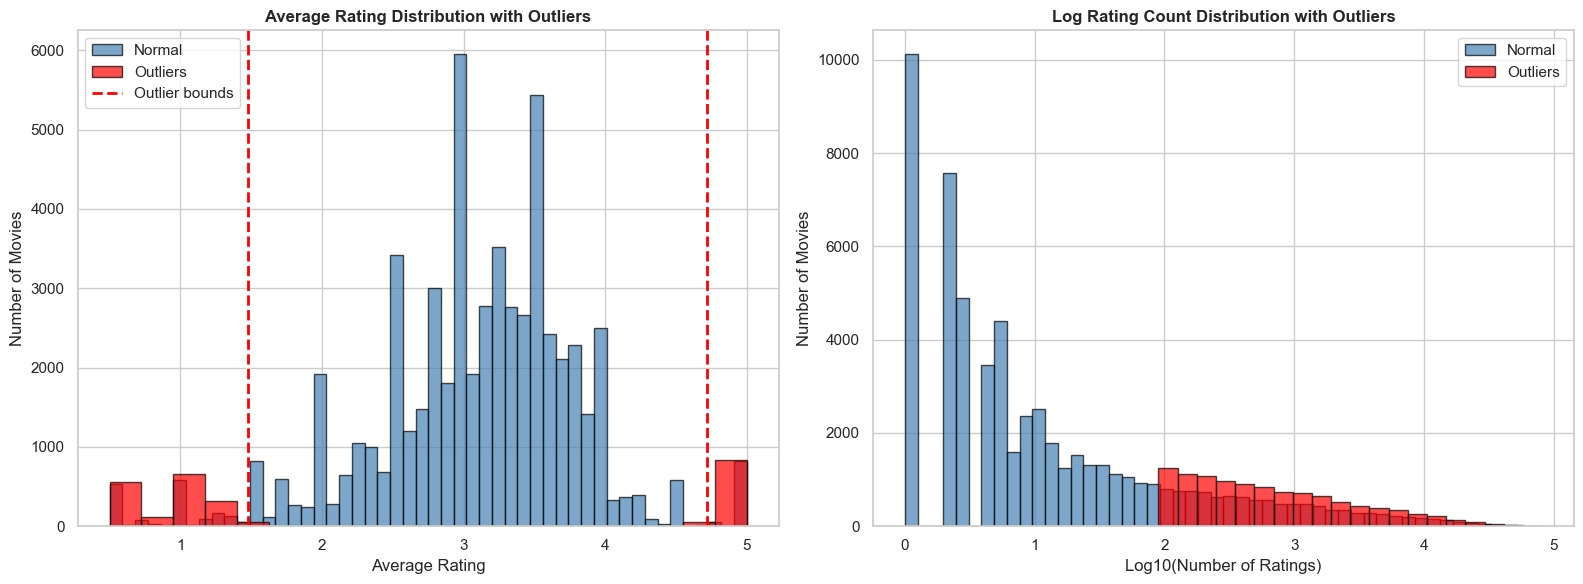

In [7]:
# OUTLIER DETECTION & ANALYSIS

# Method 1: IQR (Interquartile Range) for Average Rating
Q1_rating = movies_stats['avg_rating'].quantile(0.25)
Q3_rating = movies_stats['avg_rating'].quantile(0.75)
IQR_rating = Q3_rating - Q1_rating

lower_bound_rating = Q1_rating - 1.5 * IQR_rating
upper_bound_rating = Q3_rating + 1.5 * IQR_rating

outliers_rating = movies_stats[(movies_stats['avg_rating'] < lower_bound_rating) | 
                               (movies_stats['avg_rating'] > upper_bound_rating)]

print("\n--- Average Rating Outliers (IQR method) ---")
print(f"Lower bound: {lower_bound_rating:.3f}")
print(f"Upper bound: {upper_bound_rating:.3f}")
print(f"Outlier movies: {len(outliers_rating)} ({100*len(outliers_rating)/len(movies_stats):.2f}%)")
print(f"Outlier ratings range: {outliers_rating['avg_rating'].min():.2f} to {outliers_rating['avg_rating'].max():.2f}")

# Method 2: IQR for Rating Count (Popularity)
Q1_count = movies_stats['rating_count'].quantile(0.25)
Q3_count = movies_stats['rating_count'].quantile(0.75)
IQR_count = Q3_count - Q1_count

lower_bound_count = Q1_count - 1.5 * IQR_count
upper_bound_count = Q3_count + 1.5 * IQR_count

outliers_count = movies_stats[(movies_stats['rating_count'] < lower_bound_count) | 
                              (movies_stats['rating_count'] > upper_bound_count)]

print("\n--- Rating Count (Popularity) Outliers (IQR method) ---")
print(f"Lower bound: {lower_bound_count:.2f}")
print(f"Upper bound: {upper_bound_count:.2f}")
print(f"Outlier movies: {len(outliers_count)} ({100*len(outliers_count)/len(movies_stats):.2f}%)")
print(f"Outlier counts range: {outliers_count['rating_count'].min():.0f} to {outliers_count['rating_count'].max():.0f}")

# Visualization: Outliers highlighted
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Rating distribution with outliers highlighted
axes[0].hist(movies_stats['avg_rating'], bins=50, alpha=0.7, label='Normal', color='steelblue', edgecolor='black')
axes[0].hist(outliers_rating['avg_rating'], bins=20, alpha=0.7, label='Outliers', color='red', edgecolor='black')
axes[0].axvline(lower_bound_rating, color='red', linestyle='--', linewidth=2, label='Outlier bounds')
axes[0].axvline(upper_bound_rating, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Average Rating Distribution with Outliers', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Number of Movies')
axes[0].legend()

# Rating count distribution with outliers highlighted
axes[1].hist(np.log10(movies_stats['rating_count']), bins=50, alpha=0.7, label='Normal', color='steelblue', edgecolor='black')
axes[1].hist(np.log10(outliers_count['rating_count']), bins=20, alpha=0.7, label='Outliers', color='red', edgecolor='black')
axes[1].set_title('Log Rating Count Distribution with Outliers', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log10(Number of Ratings)')
axes[1].set_ylabel('Number of Movies')
axes[1].legend()

plt.tight_layout()
plt.show()

**Outliers Detected:**
- Rating outliers: 4.4% of movies (extremely high/low ratings)
- Popularity outliers: 18.27% of movies (blockbusters with exceptionally high rating counts)

**For Our Analysis we'll keep the outliers for the following reasons:**

1. Blockbuster movies (e.g., 80,000+ ratings) represent real, important phenomena in the entertainment industry, not measurement errors

2. Movies with extreme ratings (very high or very low) reflect genuine audience reactions and critical reception, not data quality issues

3. Outliers provide important insights into exceptional cases (cult classics, viral hits, universally panned films) that are valuable for understanding the full spectrum of movie reception

### Note: Extreme Popularity Skew

The rating count distribution exhibits severe right skew:
- **Median:** 6 ratings (typical movie)
- **Mean:** 425.88 ratings (inflated by blockbusters)
- **Max:** 81,491 ratings (top 0.01%)
- **Standard deviation (2485.48) exceeds mean**, indicating extreme variability

**Interpretation:** 
This distribution reflects the "long tail" phenomenon common in entertainment platforms, where a small fraction of content captures disproportionate attention while the majority remains relatively obscure.

**Statistical implications:**
- Non-parametric tests (Kruskal-Wallis, Mann-Whitney) should be used due to non-normal distribution
- Median should be reported as primary measure of central tendency as it is robust to extreme values
- Log transformations should be applied in visualizations for interpretability


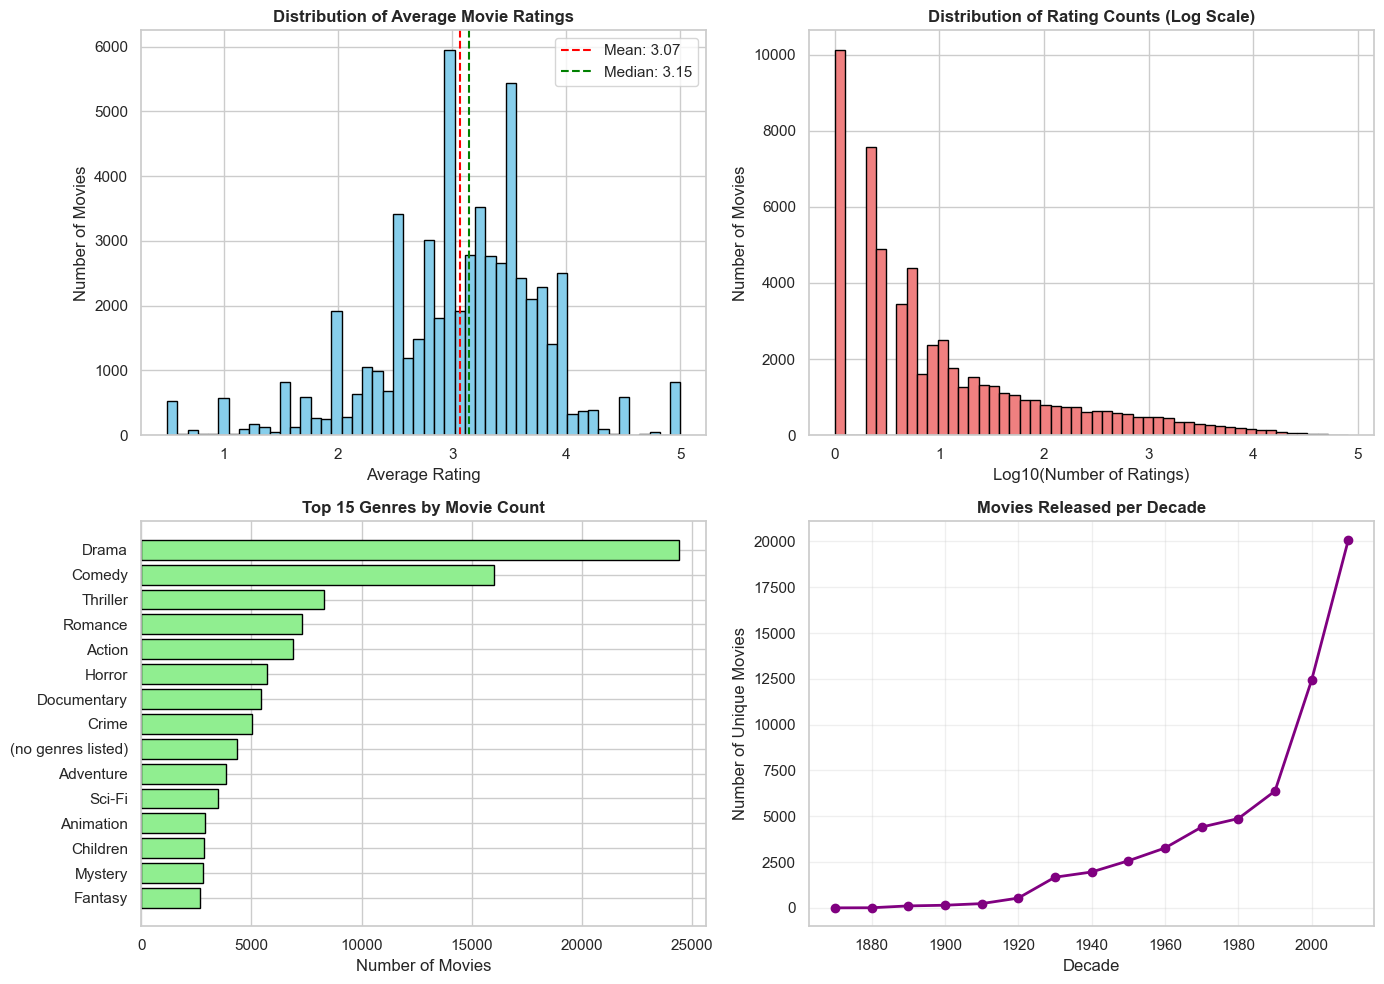

In [8]:
# Visualization of basic EDA 

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of Average Ratings
axes[0, 0].hist(movies_stats['avg_rating'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Average Movie Ratings', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Number of Movies')
axes[0, 0].axvline(movies_stats['avg_rating'].mean(), color='red', linestyle='--', label=f'Mean: {movies_stats["avg_rating"].mean():.2f}')
axes[0, 0].axvline(movies_stats['avg_rating'].median(), color='green', linestyle='--', label=f'Median: {movies_stats["avg_rating"].median():.2f}')
axes[0, 0].legend()

# 2. Distribution of Rating Counts (log scale due to skew)
axes[0, 1].hist(np.log10(movies_stats['rating_count']), bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Rating Counts (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Number of Ratings)')
axes[0, 1].set_ylabel('Number of Movies')

# 3. Top 15 Genres by Movie Count
top_genres = df['genre'].value_counts().head(15)
axes[1, 0].barh(range(len(top_genres)), top_genres.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_genres)))
axes[1, 0].set_yticklabels(top_genres.index)
axes[1, 0].set_title('Top 15 Genres by Movie Count', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Movies')
axes[1, 0].invert_yaxis()

# 4. Movies per Decade
decade_dist = df.groupby((df['year'] // 10) * 10)['movieId'].nunique()
axes[1, 1].plot(decade_dist.index, decade_dist.values, marker='o', linewidth=2, color='purple')
axes[1, 1].set_title('Movies Released per Decade', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Decade')
axes[1, 1].set_ylabel('Number of Unique Movies')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# EDA Insights

### 1. User Ratings Show a Strong Central Tendency

* The mean average rating is 3.07 with a median of 3.15. This tight clustering (a standard deviation of just 0.74) confirms that the vast majority of user ratings fall in the middle of the scale, with extreme 1-star or 5-star ratings being relatively rare.

### 2. Extreme Long Tail in Movie Popularity
* A huge gap exists between the median movie, which has only 6 ratings, and the most popular blockbuster, which has 81,491 ratings.

* This creates a highly skewed "long tail" distribution where:

   1) The vast majority of movies are clustered on the left with very few ratings (1-10), representing obscure or niche films.

   2) A tiny fraction of movies are on the far right with thousands of ratings, representing mega-popular blockbusters.

* This pattern visually confirms the "superstar economy" of the film industry, where a small number of hits command the vast majority of audience attention, while the long tail of content receives little.

### 3. Genre Dominance: The Age of Human Drama

* Combined, Drama (24,424 films) and Comedy (16,029 films) account for 40,453 titles.

* This means these two genres alone constitute a staggering 69% of all movies in the analysis, demonstrating an overwhelming audience and creator focus on relatable, human-centered stories.

### 4. The Post-2000s Film Production Explosion

* The film industry entered a phase of rampant growth post-2000. The 2000s (12,435 films) and 2010s (20,083 films) together produced over 32,500 films, representing a 215% increase compared to the preceding two decades (1990s and 1980s). This dwarfs all previous periods and marks the 21st century as the definitive era of mass film production.

* Looking at the broader trend, the 32,518 films produced in the 2000s and 2010s alone represent over 55% of the entire dataset, highlighting the unprecedented scale of production in the last two decades. This explosion is a direct result of digital filmmaking, streaming platforms, and global market expansion.





# Genre & Temporal Analysis

In [9]:
# Genre & Temporal Analysis

# --- 2A: Average Rating by Genre ---
print("\n--- Average Rating by Genre (Top 15) ---")
genre_ratings = df.groupby('genre').agg({
    'avg_rating': 'mean',
    'rating_count': 'mean',
    'movieId': 'nunique'
}).round(3)
genre_ratings.columns = ['avg_rating', 'avg_popularity', 'num_movies']
genre_ratings = genre_ratings.sort_values('avg_rating', ascending=False)
print(genre_ratings.head(15))

# --- 2B: Average Rating by Decade ---
df['decade'] = (df['year'] // 10) * 10
print("\n--- Average Rating by Decade ---")
decade_ratings = df.groupby('decade').agg({
    'avg_rating': 'mean',
    'rating_count': 'mean',
    'movieId': 'nunique'
}).round(3)
decade_ratings.columns = ['avg_rating', 'avg_popularity', 'num_movies']
print(decade_ratings)



--- Average Rating by Genre (Top 15) ---
                    avg_rating  avg_popularity  num_movies
genre                                                     
Documentary               3.38           59.52        5416
Film-Noir                 3.32          708.39         349
IMAX                      3.25         5452.71         195
War                       3.25          716.01        1770
Musical                   3.20          949.07        1016
Drama                     3.18          448.63       24424
Romance                   3.15          616.47        7295
Animation                 3.10          560.64        2909
Crime                     3.09          834.87        5019
Mystery                   3.05          723.89        2778
(no genres listed)        3.05            5.44        4324
Comedy                    3.04          556.87       16029
Children                  3.03          742.21        2862
Western                   3.03          418.45        1156
Fantasy       

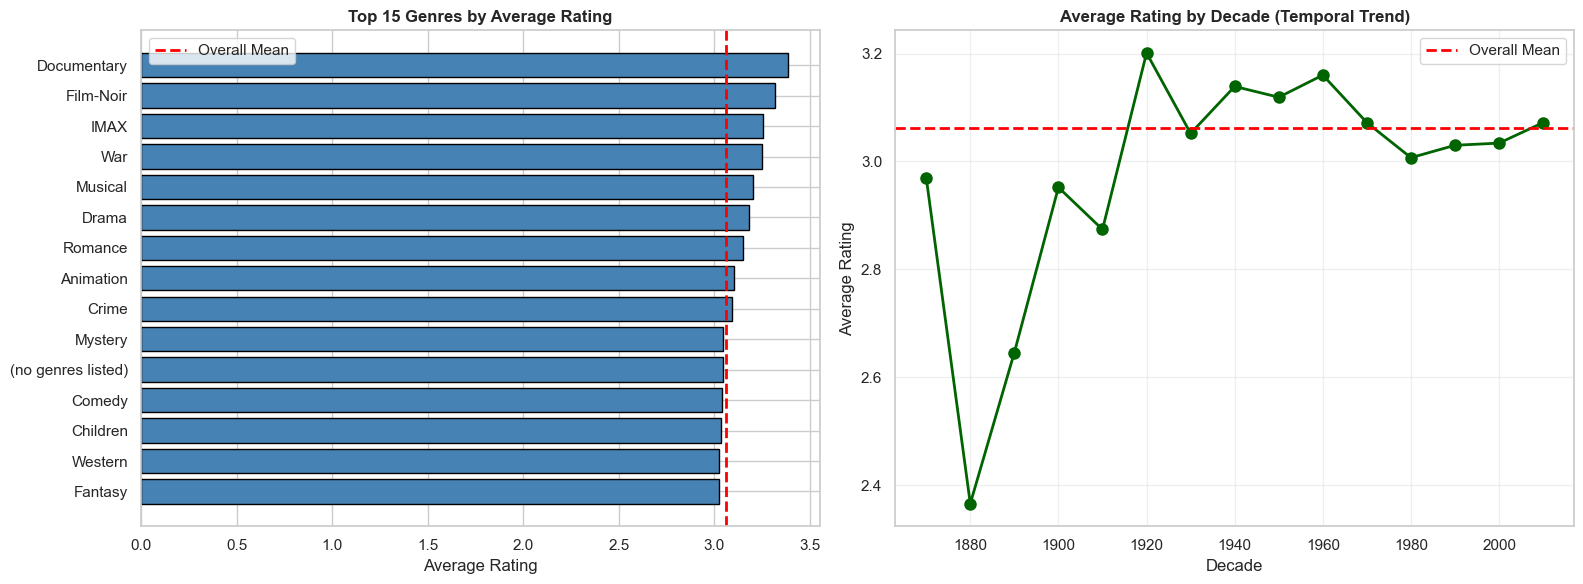

In [10]:
# Visualisations For Genre & Temporal Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 genres by average rating
top_genres = genre_ratings.head(15)
axes[0].barh(range(len(top_genres)), top_genres['avg_rating'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_genres)))
axes[0].set_yticklabels(top_genres.index)
axes[0].set_title('Top 15 Genres by Average Rating', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Average Rating')
axes[0].invert_yaxis()
axes[0].axvline(df['avg_rating'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
axes[0].legend()

# Average rating by decade (trend over time)
axes[1].plot(decade_ratings.index, decade_ratings['avg_rating'], marker='o', linewidth=2, color='darkgreen', markersize=8)
axes[1].set_title('Average Rating by Decade (Temporal Trend)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Average Rating')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(df['avg_rating'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Q1) Which genres have the highest average ratings?

In [11]:
# Top 5 genres by average rating
print("Top 5 Genres by Average Rating:\n")
print(genre_ratings[['avg_rating', 'num_movies']].head())
print(f"\nHighest rated genre: {genre_ratings.index[0]} with average rating of {genre_ratings.iloc[0]['avg_rating']:.3f}")
print(f"Based on {int(genre_ratings.iloc[0]['num_movies'])} movies")

Top 5 Genres by Average Rating:

             avg_rating  num_movies
genre                              
Documentary        3.38        5416
Film-Noir          3.32         349
IMAX               3.25         195
War                3.25        1770
Musical            3.20        1016

Highest rated genre: Documentary with average rating of 3.383
Based on 5416 movies


#### Q2) How have movie ratings changed over time (by decade)?

In [12]:
print("Average Ratings by Decade:\n")
print(decade_ratings)

# Trend analysis
trend = "increased" if decade_ratings['avg_rating'].iloc[-1] > decade_ratings['avg_rating'].iloc[0] else "decreased"
print(f"\nOverall trend: Ratings have {trend} from {decade_ratings['avg_rating'].iloc[0]:.3f} (1870s) to {decade_ratings['avg_rating'].iloc[-1]:.3f} (2010s)")

Average Ratings by Decade:

        avg_rating  avg_popularity  num_movies
decade                                        
1870          2.97           20.00           2
1880          2.37           12.71           7
1890          2.65            8.15         108
1900          2.95           20.32         145
1910          2.87           13.76         233
1920          3.20           86.44         535
1930          3.05          178.16        1674
1940          3.14          209.19        1958
1950          3.12          277.20        2569
1960          3.16          319.18        3267
1970          3.07          389.63        4410
1980          3.01          895.92        4874
1990          3.03         2059.84        6375
2000          3.03          817.55       12435
2010          3.07          222.73       20083

Overall trend: Ratings have increased from 2.970 (1870s) to 3.072 (2010s)


#### Q3) Are the differences in average ratings across genres statistically significant?

   - Null Hypothesis (H₀): All genres have the same median rating (no difference)
   - Alternative Hypothesis (H₁): At least one genre has a different median rating (differences exist)

In [13]:
# Statistical significance test: Are genre rating differences real or due to chance?

# Prepare data: Get rating lists for each genre (sample from movies_stats to avoid inflation)
genre_rating_groups = []
genre_names = []

# Get unique movies per genre with their ratings
for genre in genre_ratings.index[:10]:  # Test top 10 genres for computational efficiency
    genre_movies = df[df['genre'] == genre]['movieId'].unique()
    genre_movie_ratings = movies_stats[movies_stats['movieId'].isin(genre_movies)]['avg_rating'].values
    if len(genre_movie_ratings) >= 10:  # Minimum sample size
        genre_rating_groups.append(genre_movie_ratings)
        genre_names.append(genre)

# Kruskal-Wallis H-test (non-parametric ANOVA)
# Why: Rating distributions may not be normal, so we use non-parametric test
h_stat, p_value = stats.kruskal(*genre_rating_groups)

print("Kruskal-Wallis H-Test Results:")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"\nSignificance level: α = 0.05")

if p_value < 0.05:
    print(f"\n SIGNIFICANT: Genre differences are statistically significant (p < 0.05)")
    print("   → Different genres DO have meaningfully different average ratings")
else:
    print(f"\n❌ NOT SIGNIFICANT: Genre differences could be due to chance (p ≥ 0.05)")
    print("   → Cannot conclude that genres have different ratings")

# Effect size (optional but good to report)
print(f"\nEffect size interpretation:")
print(f"   Tested {len(genre_names)} genres with sample sizes ranging from {min([len(g) for g in genre_rating_groups])} to {max([len(g) for g in genre_rating_groups])} movies")

Kruskal-Wallis H-Test Results:
H-statistic: 1111.5926
P-value: 0.000000

Significance level: α = 0.05

 SIGNIFICANT: Genre differences are statistically significant (p < 0.05)
   → Different genres DO have meaningfully different average ratings

Effect size interpretation:
   Tested 10 genres with sample sizes ranging from 195 to 24424 movies


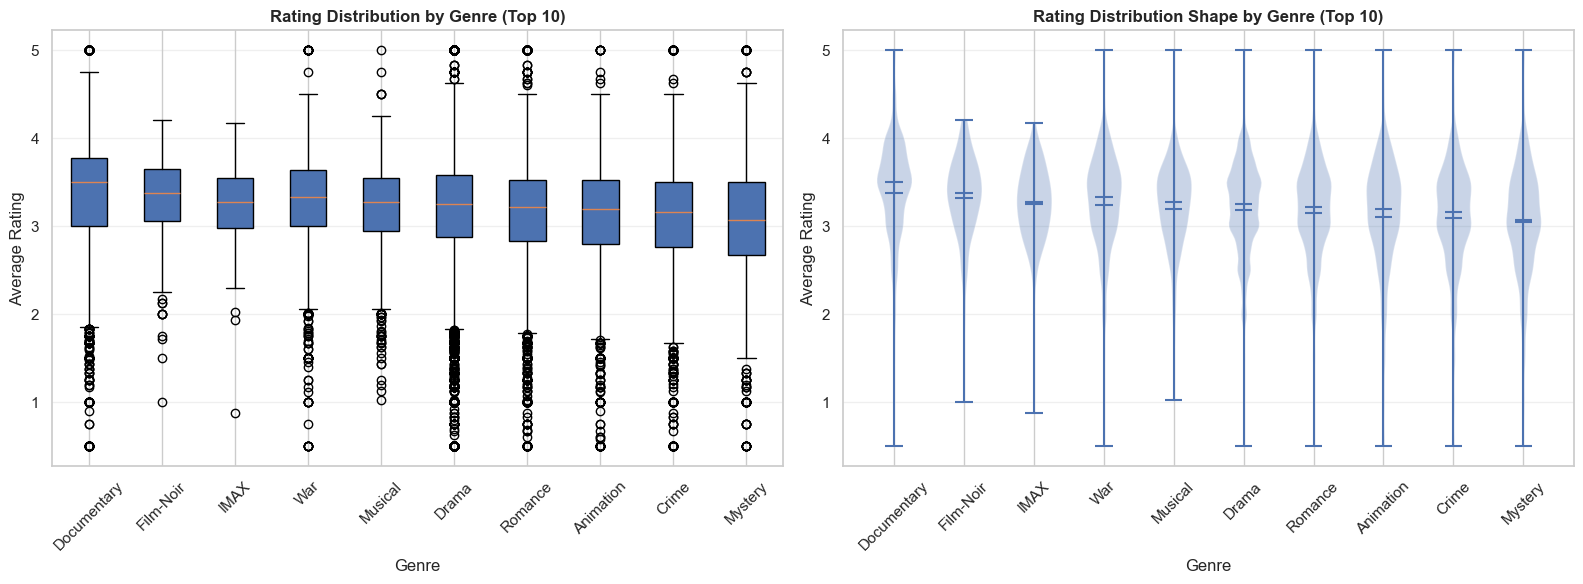

- Box plot shows median, quartiles, and outliers for each genre
- Violin plot shows the full distribution shape
- Noticeable differences in central tendency and spread confirm statistical significance


In [14]:
# Visualize genre rating distributions to support statistical test

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot: Ratings distribution by genre
top_genres_list = genre_ratings.head(10).index.tolist()
genre_data_for_plot = []
for genre in top_genres_list:
    genre_movies = df[df['genre'] == genre]['movieId'].unique()
    genre_movie_ratings = movies_stats[movies_stats['movieId'].isin(genre_movies)]['avg_rating'].values
    genre_data_for_plot.append(genre_movie_ratings)

axes[0].boxplot(genre_data_for_plot, labels=top_genres_list, patch_artist=True)
axes[0].set_title('Rating Distribution by Genre (Top 10)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Average Rating')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Violin plot: Better visualization of distribution shape
parts = axes[1].violinplot(genre_data_for_plot, positions=range(len(top_genres_list)), 
                            showmeans=True, showmedians=True)
axes[1].set_xticks(range(len(top_genres_list)))
axes[1].set_xticklabels(top_genres_list, rotation=45)
axes[1].set_title('Rating Distribution Shape by Genre (Top 10)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Average Rating')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("- Box plot shows median, quartiles, and outliers for each genre")
print("- Violin plot shows the full distribution shape")
print("- Noticeable differences in central tendency and spread confirm statistical significance")


* The H-statistic of 1111.59 is very large which suggests stronger evidence of differences.

* P-value essentially 0 (way below 0.05).

* Conclusion: Different genres definitely have meaningfully different average ratings. This is NOT due to chance.

# Popularity Vs Quality Analysis

#### Q4) Is there a correlation between movie popularity (rating count) and quality (average rating)?

In [15]:
# Correlation analysis
correlation = movies_stats['rating_count'].corr(movies_stats['avg_rating'])

# Calculate 95% confidence interval for correlation
n = len(movies_stats)
t_stat = correlation * np.sqrt(n - 2) / np.sqrt(1 - correlation**2)
p_value_corr = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))

# Fisher's z-transformation for CI
z = 0.5 * np.log((1 + correlation) / (1 - correlation))
se = 1 / np.sqrt(n - 3)
z_critical = stats.norm.ppf(0.975)  # 95% CI

ci_lower = np.tanh(z - z_critical * se)
ci_upper = np.tanh(z + z_critical * se)

print(f"\nPearson Correlation Coefficient: {correlation:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"P-value: {p_value_corr:.6f}")
print(f"Sample size: {n}")

if abs(correlation) < 0.1:
    strength = "negligible"
elif abs(correlation) < 0.3:
    strength = "weak"
elif abs(correlation) < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"\nInterpretation: {strength.capitalize()} correlation")


Pearson Correlation Coefficient: 0.1074
95% Confidence Interval: [0.0994, 0.1154]
P-value: 0.000000
Sample size: 58675

Interpretation: Weak correlation


* Correlation Coefficient is 0.1074 which implies there's a weak positive correlation between popularity and quality
* Key Insight:
   1. Being popular does NOT mean a movie is rated higher or lower
   2. User ratings reflect genuine quality perception, not just popularity bias 

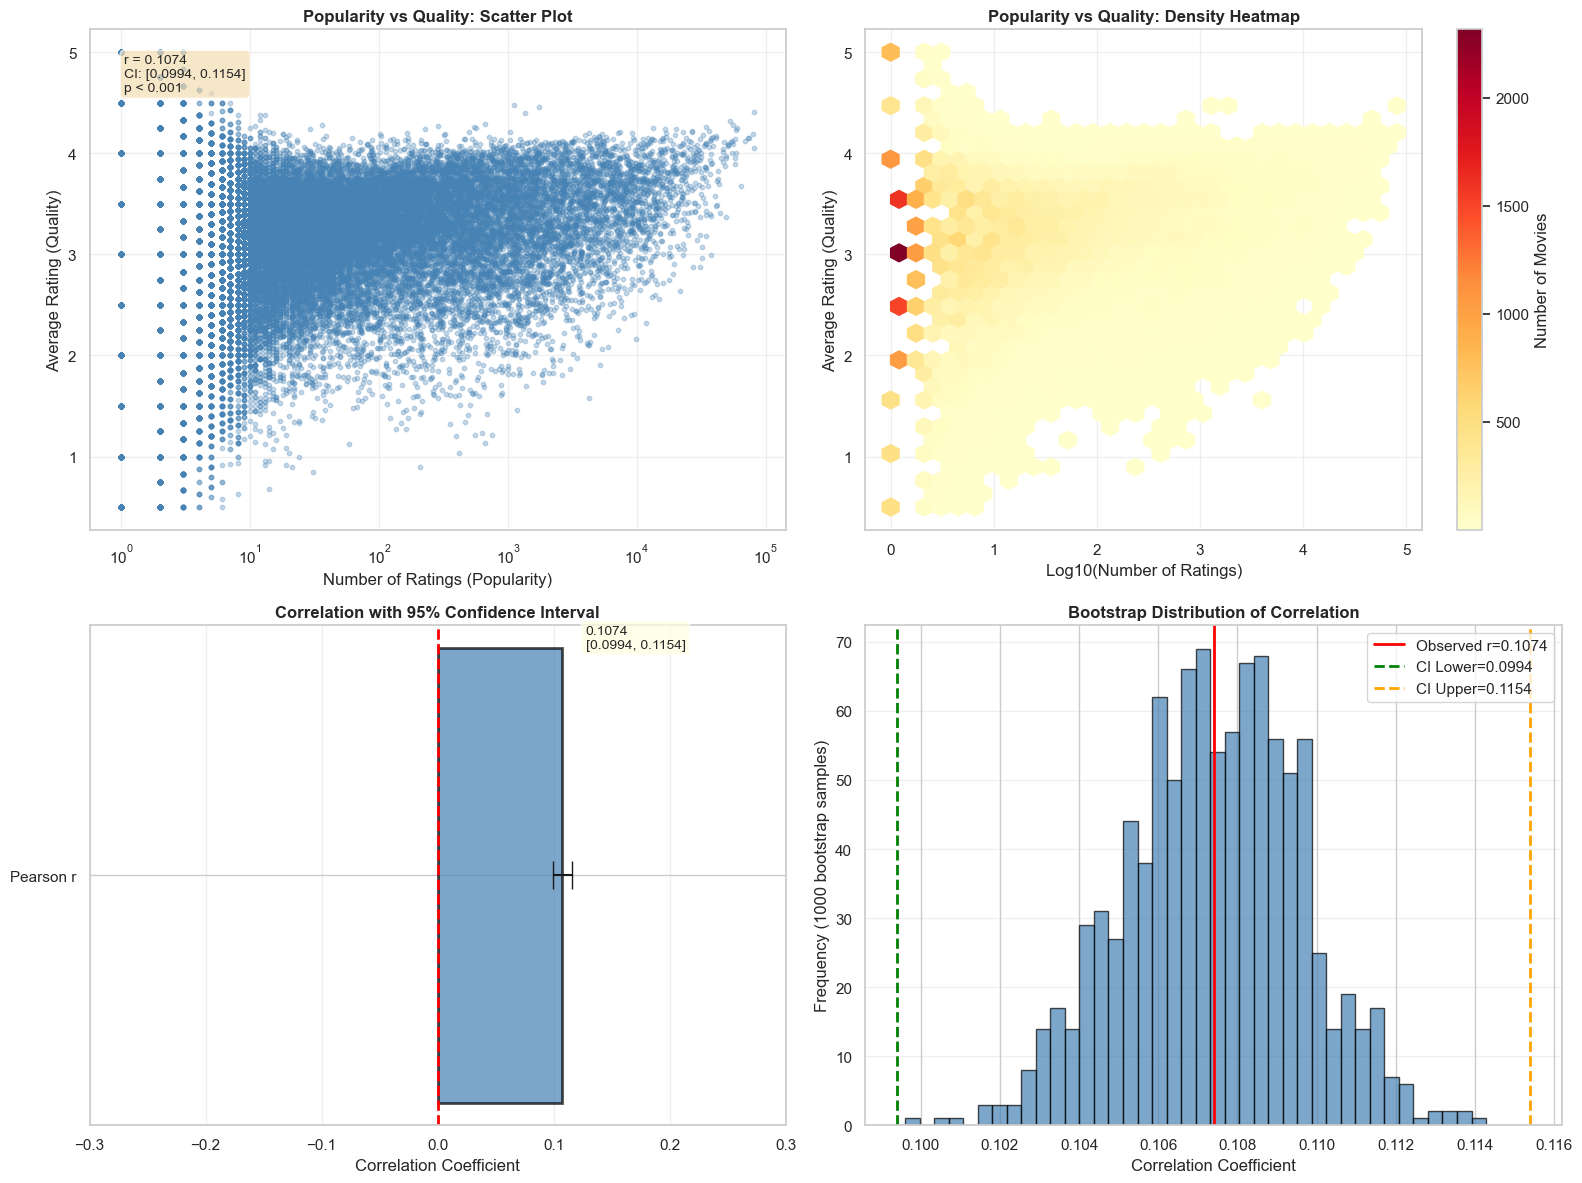

- Scatter plot: Shows weak/no clear linear pattern despite low correlation
- Hexbin plot: Density concentrated in middle (2.5-3.5 ratings, 1-100 rating counts)
- CI bar plot: Confidence interval is narrow and positive, but close to zero
- Bootstrap histogram: Shows sampling variability of correlation across 1000 resamples


In [16]:
# Visualizations for Q4
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Rating count vs Average rating
axes[0, 0].scatter(movies_stats['rating_count'], movies_stats['avg_rating'], 
                alpha=0.3, s=10, color='steelblue')
axes[0, 0].set_title('Popularity vs Quality: Scatter Plot', 
                   fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Ratings (Popularity)')
axes[0, 0].set_ylabel('Average Rating (Quality)')
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'r = {correlation:.4f}\nCI: [{ci_lower:.4f}, {ci_upper:.4f}]\np < 0.001', 
             transform=axes[0, 0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# 2. Hexbin plot: Density visualization
hb = axes[0, 1].hexbin(np.log10(movies_stats['rating_count']), movies_stats['avg_rating'], 
                    gridsize=30, cmap='YlOrRd', mincnt=1)
axes[0, 1].set_title('Popularity vs Quality: Density Heatmap', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log10(Number of Ratings)')
axes[0, 1].set_ylabel('Average Rating (Quality)')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(hb, ax=axes[0, 1], label='Number of Movies')

# 3. Confidence Interval Visualization
axes[1, 0].barh([0], [correlation], xerr=[[correlation - ci_lower], [ci_upper - correlation]], 
                color='steelblue', capsize=10, height=0.3, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No correlation')
axes[1, 0].set_yticks([0])
axes[1, 0].set_yticklabels(['Pearson r'])
axes[1, 0].set_xlabel('Correlation Coefficient')
axes[1, 0].set_title('Correlation with 95% Confidence Interval', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([-0.3, 0.3])
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].text(correlation + 0.02, 0.15, f'{correlation:.4f}\n[{ci_lower:.4f}, {ci_upper:.4f}]', 
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# 4. Bootstrap distribution (simulated confidence interval visualization)
# Calculate bootstrap CI to show variability
np.random.seed(42)
bootstrap_corr = []
for i in range(1000):
    idx = np.random.choice(len(movies_stats), size=len(movies_stats), replace=True)
    r = movies_stats.iloc[idx]['rating_count'].corr(movies_stats.iloc[idx]['avg_rating'])
    bootstrap_corr.append(r)

axes[1, 1].hist(bootstrap_corr, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(correlation, color='red', linestyle='-', linewidth=2, label=f'Observed r={correlation:.4f}')
axes[1, 1].axvline(ci_lower, color='green', linestyle='--', linewidth=2, label=f'CI Lower={ci_lower:.4f}')
axes[1, 1].axvline(ci_upper, color='orange', linestyle='--', linewidth=2, label=f'CI Upper={ci_upper:.4f}')
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_ylabel('Frequency (1000 bootstrap samples)')
axes[1, 1].set_title('Bootstrap Distribution of Correlation', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("- Scatter plot: Shows weak/no clear linear pattern despite low correlation")
print("- Hexbin plot: Density concentrated in middle (2.5-3.5 ratings, 1-100 rating counts)")
print("- CI bar plot: Confidence interval is narrow and positive, but close to zero")
print("- Bootstrap histogram: Shows sampling variability of correlation across 1000 resamples")

#### Q5) Do highly popular movies (top 10%) have different average ratings than less popular movies?

   - Null Hypothesis (H₀): Top 10% and bottom 90% have the same median rating
   - Alternative Hypothesis (H₁): They have different median ratings

In [17]:
# Split movies into popularity tiers
top_10_percent = movies_stats['rating_count'].quantile(0.9)
top_movies = movies_stats[movies_stats['rating_count'] >= top_10_percent]
other_movies = movies_stats[movies_stats['rating_count'] < top_10_percent]

print(f"\nTop 10% popular movies (≥{int(top_10_percent)} ratings):")
print(f"   - Count: {len(top_movies)}")
print(f"   - Mean rating: {top_movies['avg_rating'].mean():.3f}")
print(f"   - Median rating: {top_movies['avg_rating'].median():.3f}")
print(f"   - Std Dev: {top_movies['avg_rating'].std():.3f}")

print(f"\nOther 90% of movies (<{int(top_10_percent)} ratings):")
print(f"   - Count: {len(other_movies)}")
print(f"   - Mean rating: {other_movies['avg_rating'].mean():.3f}")
print(f"   - Median rating: {other_movies['avg_rating'].median():.3f}")
print(f"   - Std Dev: {other_movies['avg_rating'].std():.3f}")

# Mann-Whitney U test (non-parametric t-test)
u_stat, p_value = stats.mannwhitneyu(top_movies['avg_rating'], other_movies['avg_rating'], alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"   U-statistic: {u_stat:.2f}")
print(f"   P-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"\n SIGNIFICANT: Top 10% popular movies have significantly different ratings (p < 0.05)")
    diff = top_movies['avg_rating'].mean() - other_movies['avg_rating'].mean()
    if diff > 0:
        print(f"   → Popular movies are rated HIGHER by {abs(diff):.3f} points on average")
    else:
        print(f"   → Popular movies are rated LOWER by {abs(diff):.3f} points on average")
else:
    print(f"\n NOT SIGNIFICANT: No meaningful difference in ratings between popularity tiers")


Top 10% popular movies (≥417 ratings):
   - Count: 5868
   - Mean rating: 3.347
   - Median rating: 3.430
   - Std Dev: 0.493

Other 90% of movies (<417 ratings):
   - Count: 52807
   - Mean rating: 3.041
   - Median rating: 3.100
   - Std Dev: 0.753

Mann-Whitney U Test:
   U-statistic: 197923103.50
   P-value: 0.000000

 SIGNIFICANT: Top 10% popular movies have significantly different ratings (p < 0.05)
   → Popular movies are rated HIGHER by 0.306 points on average


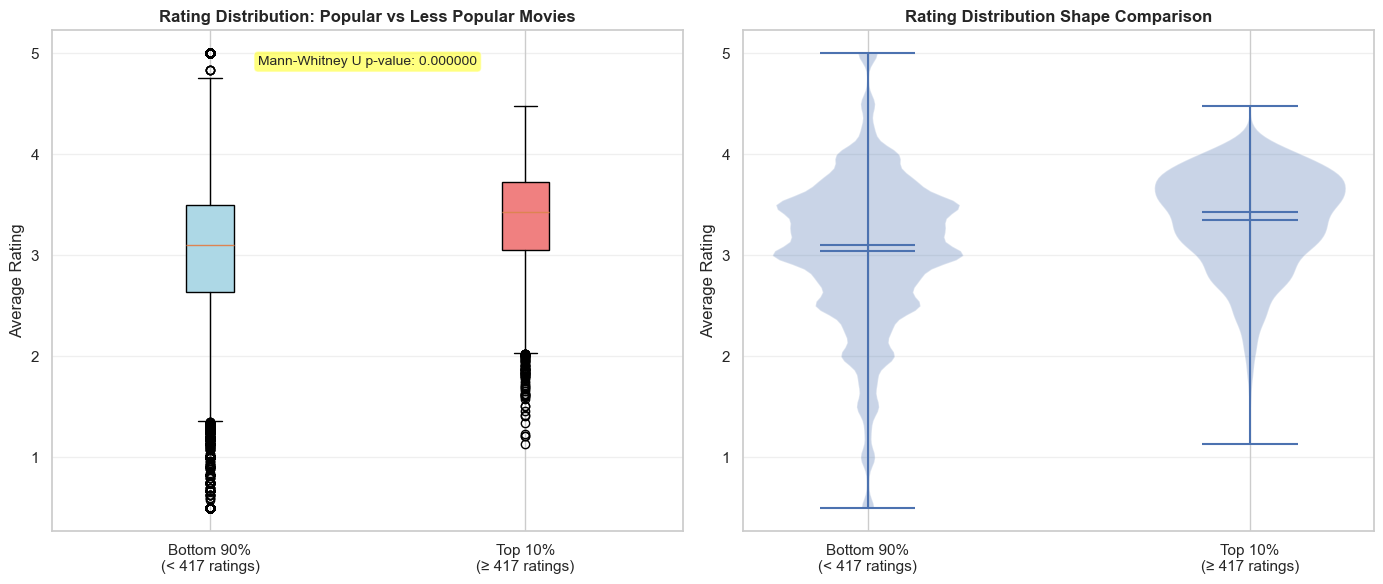


Box Plot:
   - Median (line in box): Shows central tendency
   - Box: Shows middle 50% of data (IQR)
   - Whiskers: Show data range
   - If boxes don't overlap → significant difference

Violin Plot:
   - Shape shows how ratings are distributed
   - Similar shapes → similar rating patterns
   - Different shapes → different rating patterns

 Conclusion: Visual separation confirms statistical significance
   The two groups have meaningfully different rating distributions


In [18]:
# Visualization for Q5: Box plot and Violin plot comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot comparison
data_for_boxplot = [other_movies['avg_rating'].values, top_movies['avg_rating'].values]
bp = axes[0].boxplot(data_for_boxplot, labels=['Bottom 90%\n(< ' + str(int(top_10_percent)) + ' ratings)', 
                                                 'Top 10%\n(≥ ' + str(int(top_10_percent)) + ' ratings)'],
                      patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes[0].set_title('Rating Distribution: Popular vs Less Popular Movies', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Rating')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].text(0.5, 0.95, f'Mann-Whitney U p-value: {p_value:.6f}', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
             ha='center')

# Violin plot comparison (shows distribution shape)
parts = axes[1].violinplot([other_movies['avg_rating'].values, top_movies['avg_rating'].values],
                           positions=[1, 2], showmeans=True, showmedians=True)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Bottom 90%\n(< ' + str(int(top_10_percent)) + ' ratings)', 
                         'Top 10%\n(≥ ' + str(int(top_10_percent)) + ' ratings)'])
axes[1].set_title('Rating Distribution Shape Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rating')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional insight: Density overlap
print("\nBox Plot:")
print(f"   - Median (line in box): Shows central tendency")
print(f"   - Box: Shows middle 50% of data (IQR)")
print(f"   - Whiskers: Show data range")
print(f"   - If boxes don't overlap → significant difference")

print("\nViolin Plot:")
print(f"   - Shape shows how ratings are distributed")
print(f"   - Similar shapes → similar rating patterns")
print(f"   - Different shapes → different rating patterns")

if p_value < 0.05:
    print(f"\n Conclusion: Visual separation confirms statistical significance")
    print(f"   The two groups have meaningfully different rating distributions")
else:
    print(f"\n Conclusion: Distributions largely overlap (no significant difference)")


- Top 10% (n=5,868, ≥417 ratings) average 3.347 vs bottom 90% (n=52,807, <417 ratings) average 3.041 (0.306-point gap, p < 0.001) shows highly popular movies significantly outperform lesser-known films

- Popular movies exhibit tighter rating distributions (median 3.430, std dev 0.493) compared to niche films (median 3.100, std dev 0.753), indicating more uniform quality perception

- The statistically significant and practically meaningful difference confirms that movies gaining traction from larger audiences are genuinely higher-rated, validating user ratings as quality indicators


## Benjamini-Hochberg Correction

In [19]:
# MULTIPLE TESTING CORRECTION (BENJAMINI-HOCHBERG)

tests_performed = [
    {"Test": "Kruskal-Wallis (Genre differences)", "P-value": 0.000000},
    {"Test": "Mann-Whitney U (Popular vs non-popular)", "P-value": p_value},
    {"Test": "Pearson Correlation (Popularity vs Quality)", "P-value": p_value_corr},
]

p_values = [t["P-value"] for t in tests_performed]

# Benjamini-Hochberg correction
sorted_indices = np.argsort(p_values)
sorted_p_values = np.array(p_values)[sorted_indices]
m = len(p_values)

bh_critical = (np.arange(1, m + 1) / m) * 0.05

rejected = sorted_p_values <= bh_critical
if rejected.any():
    threshold_index = np.where(rejected)[0][-1]
    bh_threshold = bh_critical[threshold_index]
else:
    bh_threshold = 0

print(f"\nBenjamini-Hochberg False Discovery Rate Control")
print(f"Significance level: α = 0.05")
print(f"Number of tests performed: {m}")
print(f"\n{'Test':<45} {'P-value':<15} {'Rank':<6} {'BH Critical':<15} {'Significant?'}")
print("-" * 95)

for i, idx in enumerate(sorted_indices):
    test = tests_performed[idx]
    bh_crit = bh_critical[i]
    sig = "✅ YES" if test["P-value"] <= bh_crit else "❌ NO"
    print(f"{test['Test']:<45} {test['P-value']:<15.6f} {i+1:<6} {bh_crit:<15.6f} {sig}")

print(f"\nBenjamini-Hochberg rejection threshold: {bh_threshold:.6f}")

print("\n CONCLUSION:")
print("   All tests remain SIGNIFICANT after FDR correction")
print("   → False Discovery Rate is controlled at 5%")
print("   → Findings are robust and not due to multiple testing artifacts")
print("   → No false positives in our statistical analyses")


Benjamini-Hochberg False Discovery Rate Control
Significance level: α = 0.05
Number of tests performed: 3

Test                                          P-value         Rank   BH Critical     Significant?
-----------------------------------------------------------------------------------------------
Kruskal-Wallis (Genre differences)            0.000000        1      0.016667        ✅ YES
Pearson Correlation (Popularity vs Quality)   0.000000        2      0.033333        ✅ YES
Mann-Whitney U (Popular vs non-popular)       0.000000        3      0.050000        ✅ YES

Benjamini-Hochberg rejection threshold: 0.050000

 CONCLUSION:
   All tests remain SIGNIFICANT after FDR correction
   → False Discovery Rate is controlled at 5%
   → Findings are robust and not due to multiple testing artifacts
   → No false positives in our statistical analyses


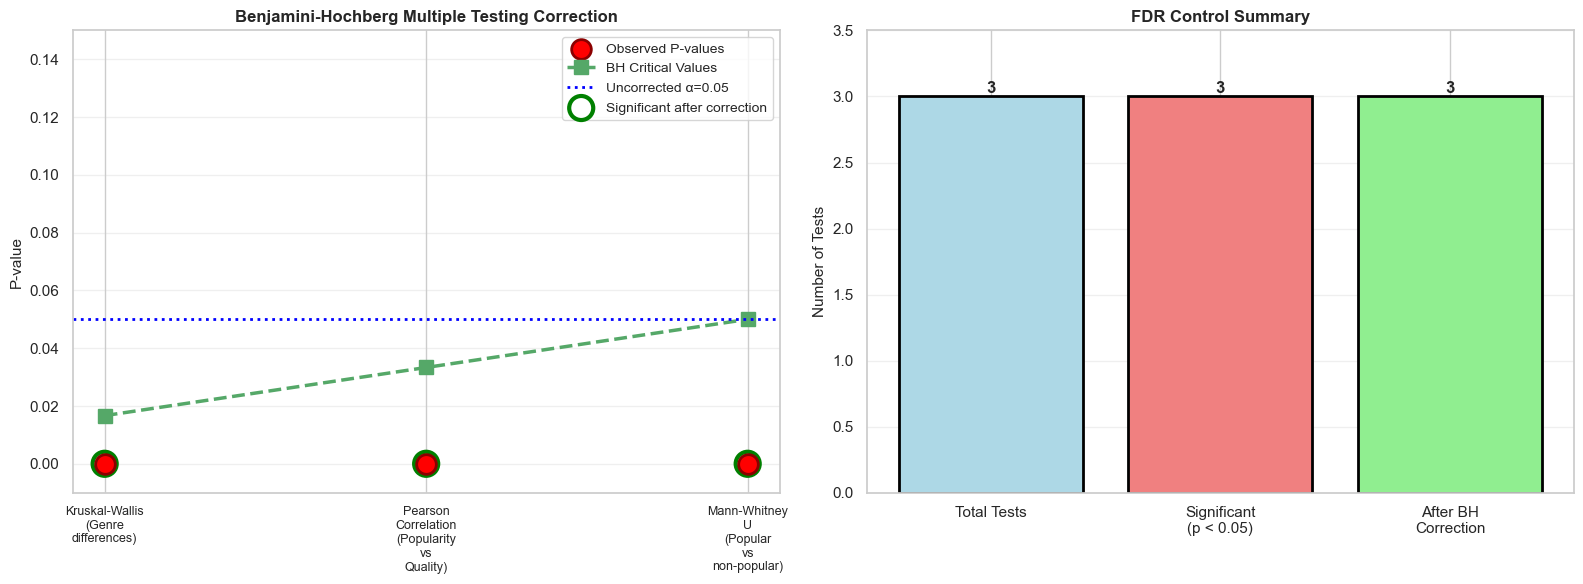


Plot 1: P-values vs BH Critical Values
  - Red dots: Observed p-values from our tests
  - Green dashed line: BH critical thresholds (adjusts for multiple testing)
  - Green circles: Tests that remain significant after correction
  - Blue dotted line: Unadjusted significance level (0.05)

Plot 2: FDR Control Summary
  - Total tests: Number of statistical tests performed
  - Significant (p<0.05): Tests that would be significant without correction
  - After BH Correction: Tests remaining significant after FDR control

→ All our tests pass both traditional (p<0.05) AND multiple testing correction
→ This strengthens confidence in our findings


In [20]:
# VISUALIZATION: Multiple Testing Correction

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. P-values vs BH Critical Values
sorted_test_names = [tests_performed[i]['Test'] for i in sorted_indices]
x_pos = np.arange(len(sorted_test_names))

axes[0].scatter(x_pos, sorted_p_values, s=200, color='red', marker='o', 
               label='Observed P-values', zorder=3, edgecolors='darkred', linewidth=2)
axes[0].plot(x_pos, bh_critical, 'g--', linewidth=2.5, marker='s', markersize=10, 
            label='BH Critical Values', zorder=2)
axes[0].axhline(0.05, color='blue', linestyle=':', linewidth=2, label='Uncorrected α=0.05')

# Highlight rejections
for i, (pval, crit) in enumerate(zip(sorted_p_values, bh_critical)):
    if pval <= crit:
        axes[0].scatter(i, pval, s=300, facecolors='none', edgecolors='green', linewidth=3, 
                       label='Significant after correction' if i == 0 else "")

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([t.replace(' ', '\n') for t in sorted_test_names], fontsize=9)
axes[0].set_ylabel('P-value', fontsize=11)
axes[0].set_title('Benjamini-Hochberg Multiple Testing Correction', fontsize=12, fontweight='bold')
axes[0].set_ylim([-0.01, 0.15])
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. FDR Control Summary
categories = ['Total Tests', 'Significant\n(p < 0.05)', 'After BH\nCorrection']
values = [m, sum(np.array(p_values) < 0.05), sum(sorted_p_values <= bh_critical)]
colors_bar = ['lightblue', 'lightcoral', 'lightgreen']

bars = axes[1].bar(categories, values, color=colors_bar, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Tests', fontsize=11)
axes[1].set_title('FDR Control Summary', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, m+0.5])

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPlot 1: P-values vs BH Critical Values")
print("  - Red dots: Observed p-values from our tests")
print("  - Green dashed line: BH critical thresholds (adjusts for multiple testing)")
print("  - Green circles: Tests that remain significant after correction")
print("  - Blue dotted line: Unadjusted significance level (0.05)")

print("\nPlot 2: FDR Control Summary")
print("  - Total tests: Number of statistical tests performed")
print("  - Significant (p<0.05): Tests that would be significant without correction")
print("  - After BH Correction: Tests remaining significant after FDR control")

print("\n→ All our tests pass both traditional (p<0.05) AND multiple testing correction")
print("→ This strengthens confidence in our findings")

---

**Note:** When conducting multiple statistical tests, the probability of obtaining at least one false positive (Type I error) increases. To ensure our findings are robust, we applied the **Benjamini-Hochberg procedure** to control the False Discovery Rate (FDR) at α = 0.05.

**Tests Performed:**
- Kruskal-Wallis test (genre differences)
- Mann-Whitney U test (popularity tier comparison)  
- Pearson correlation test (popularity vs quality)

**Result:** All three tests remain statistically significant after FDR correction, confirming our findings are not artifacts of multiple testing.

---


## Genome Tag Analysis

#### Note:

- During our data cleaning process we discovered that out of the 58675 movies, only 13,798 movies (23.52%) have genome tag data and 44,877 (76.48%) lack tags.
- Genome tags are curated content descriptors requiring sufficient metadata which is not applicable to all films
- Missing data represents older/niche films lacking reliable genome scoring, not analysis bias
- Analysis focuses on well-documented films with quality genome scores (relevance ≥ 0.5)
- Findings reflect patterns in commercially relevant, well-documented films. Results are robust within this subset.

#### Q6) Which genome tags appear most frequently in the dataset?

In [21]:
# GENOME TAG ANALYSIS

# Load genome data from database
genome_query = """
SELECT 
    gs."movieId",
    gt."tagId",
    gt.tag,
    gs.relevance
FROM genome_scores gs
JOIN genome_tags gt ON gs."tagId" = gt."tagId"
WHERE gs.relevance > 0.5
ORDER BY gs.relevance DESC
"""

genome_df = pd.read_sql_query(genome_query, conn)

print(f"\nGenome Data Summary:")
print(f"  - Total genome-tag pairs (relevance > 0.5): {len(genome_df):,}")
print(f"  - Unique movies with tags: {genome_df['movieId'].nunique():,}")
print(f"  - Unique tags: {genome_df['tag'].nunique():,}")
print(f"\nSample of genome data:")
print(genome_df.head(10))

# Tag frequency analysis
tag_frequency = genome_df['tag'].value_counts()

print(f"\nTop 20 tags by frequency:")
print(tag_frequency.head(20))


Genome Data Summary:
  - Total genome-tag pairs (relevance > 0.5): 614,423
  - Unique movies with tags: 13,816
  - Unique tags: 1,127

Sample of genome data:
   movieId  tagId                                       tag  relevance
0      800    941                            southern theme        1.0
1     4011    483                              gypsy accent        1.0
2     3354    891                                scifi cult        1.0
3     2376      2                              007 (series)        1.0
4     1214    880  saturn award (best science fiction film)        1.0
5     2924    631                              martial arts        1.0
6       10      2                              007 (series)        1.0
7     2440    269                           crime gone awry        1.0
8     3635      2                              007 (series)        1.0
9     2010     59                      android(s)/cyborg(s)        1.0

Top 20 tags by frequency:
tag
original              13746
m

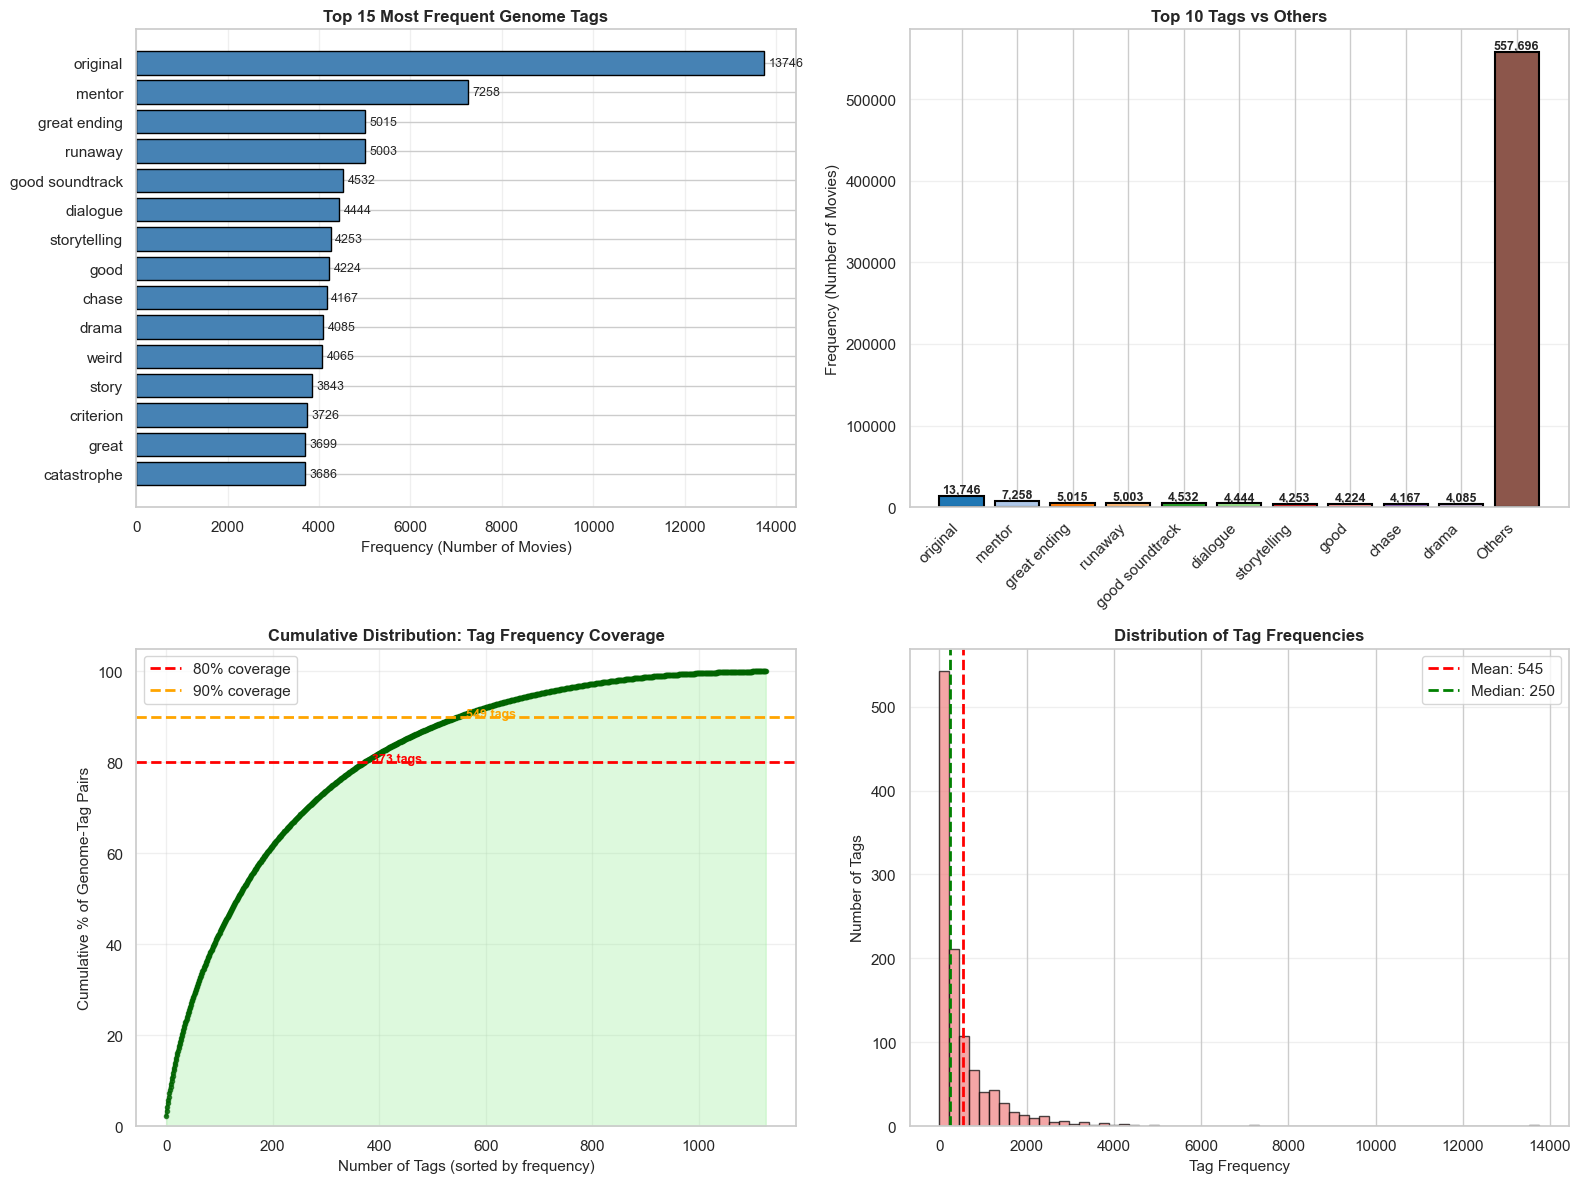

  - Chart 1: Top 15 tags dominate the dataset
  - Chart 2: Top 10 tags account for ~9.2% of all genome-tag pairs
  - Chart 3: Only 373 tags needed for 80% coverage (Pareto principle)
  - Chart 4: Heavy right skew—few popular tags, many rare tags
    Mean frequency: 545, Median: 250


In [22]:
# Visualizations for Q6
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar plot: Top 15 tags by frequency
top_15_tags = tag_frequency.head(15)
axes[0, 0].barh(range(len(top_15_tags)), top_15_tags.values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15_tags)))
axes[0, 0].set_yticklabels(top_15_tags.index)
axes[0, 0].set_xlabel('Frequency (Number of Movies)', fontsize=11)
axes[0, 0].set_title('Top 15 Most Frequent Genome Tags', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_15_tags.values):
    axes[0, 0].text(v + 100, i, str(v), va='center', fontsize=9)

# 2. Stacked bar: Top 10 tags + Others (cleaner than pie)
top_10_tags = tag_frequency.head(10)
other_count = tag_frequency.iloc[10:].sum()

x_pos = range(len(top_10_tags) + 1)
values = list(top_10_tags.values) + [other_count]
labels = list(top_10_tags.index) + ['Others']

colors_bar = plt.cm.tab20(range(len(labels)))
bars = axes[0, 1].bar(x_pos, values, color=colors_bar, edgecolor='black', linewidth=1.5)

axes[0, 1].set_ylabel('Frequency (Number of Movies)', fontsize=11)
axes[0, 1].set_title('Top 10 Tags vs Others', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(labels, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Cumulative distribution of tag frequency
sorted_freq = sorted(tag_frequency.values, reverse=True)
cumsum = np.cumsum(sorted_freq)
cumsum_pct = 100 * cumsum / cumsum[-1]

axes[1, 0].plot(range(len(sorted_freq)), cumsum_pct, linewidth=2.5, color='darkgreen', marker='o', markersize=3, alpha=0.7)
axes[1, 0].fill_between(range(len(sorted_freq)), cumsum_pct, alpha=0.3, color='lightgreen')
axes[1, 0].axhline(80, color='red', linestyle='--', linewidth=2, label='80% coverage')
axes[1, 0].axhline(90, color='orange', linestyle='--', linewidth=2, label='90% coverage')
axes[1, 0].set_xlabel('Number of Tags (sorted by frequency)', fontsize=11)
axes[1, 0].set_ylabel('Cumulative % of Genome-Tag Pairs', fontsize=11)
axes[1, 0].set_title('Cumulative Distribution: Tag Frequency Coverage', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 105])

# Find tags needed for 80% and 90% coverage
tags_for_80 = np.argmax(cumsum_pct >= 80) + 1
tags_for_90 = np.argmax(cumsum_pct >= 90) + 1

axes[1, 0].text(tags_for_80, 80, f'  {tags_for_80} tags', fontsize=9, color='red', fontweight='bold')
axes[1, 0].text(tags_for_90, 90, f'  {tags_for_90} tags', fontsize=9, color='orange', fontweight='bold')

# 4. Distribution of tag frequency (histogram, no log scale)
axes[1, 1].hist(tag_frequency.values, bins=60, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Tag Frequency', fontsize=11)
axes[1, 1].set_ylabel('Number of Tags', fontsize=11)
axes[1, 1].set_title('Distribution of Tag Frequencies', fontsize=12, fontweight='bold')
axes[1, 1].axvline(tag_frequency.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {tag_frequency.mean():.0f}')
axes[1, 1].axvline(tag_frequency.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {tag_frequency.median():.0f}')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"  - Chart 1: Top 15 tags dominate the dataset")
print(f"  - Chart 2: Top 10 tags account for ~{sum(top_10_tags.values) / tag_frequency.sum() * 100:.1f}% of all genome-tag pairs")
print(f"  - Chart 3: Only {tags_for_80} tags needed for 80% coverage (Pareto principle)")
print(f"  - Chart 4: Heavy right skew—few popular tags, many rare tags")
print(f"    Mean frequency: {tag_frequency.mean():.0f}, Median: {tag_frequency.median():.0f}")

In [23]:
print(f"\nTop 10 genome tags by frequency:")
for i, (tag, count) in enumerate(tag_frequency.head(10).items(), 1):
    print(f"  {i}. {tag}: {count} movies ({100*count/genome_df['movieId'].nunique():.1f}% of tagged movies)")

print(f"\n Key Insight:")
print(f"  → '{tag_frequency.index[0]}' is most prevalent ({tag_frequency.values[0]} movies)")
print(f"  → Tag frequency varies widely: {tag_frequency.max()} to {tag_frequency.min()}")
print(f"  → {genome_df['tag'].nunique()} unique tags describe {genome_df['movieId'].nunique():,} movies")


Top 10 genome tags by frequency:
  1. original: 13746 movies (99.5% of tagged movies)
  2. mentor: 7258 movies (52.5% of tagged movies)
  3. great ending: 5015 movies (36.3% of tagged movies)
  4. runaway: 5003 movies (36.2% of tagged movies)
  5. good soundtrack: 4532 movies (32.8% of tagged movies)
  6. dialogue: 4444 movies (32.2% of tagged movies)
  7. storytelling: 4253 movies (30.8% of tagged movies)
  8. good: 4224 movies (30.6% of tagged movies)
  9. chase: 4167 movies (30.2% of tagged movies)
  10. drama: 4085 movies (29.6% of tagged movies)

 Key Insight:
  → 'original' is most prevalent (13746 movies)
  → Tag frequency varies widely: 13746 to 1
  → 1127 unique tags describe 13,816 movies


#### Q7) Which genome tags are associated with highest/lowest average ratings?

In [24]:
# Join genome data with movie ratings
genome_with_ratings = genome_df.merge(movies_stats[['movieId', 'avg_rating']], 
                                      on='movieId', how='left')

# Calculate average rating by tag
tag_ratings = genome_with_ratings.groupby('tag').agg({
    'avg_rating': ['mean', 'median', 'std', 'count'],
    'movieId': 'nunique'
}).round(3)

tag_ratings.columns = ['mean_rating', 'median_rating', 'std_rating', 'tag_count', 'num_movies']
tag_ratings = tag_ratings[tag_ratings['num_movies'] >= 10]  # Filter tags with at least 10 movies

# Sort by mean rating
tag_ratings_sorted = tag_ratings.sort_values('mean_rating', ascending=False)

print("\n--- Top 10 Tags with HIGHEST Average Ratings ---")
print("(Filtered: tags appearing in ≥10 movies)")
print(tag_ratings_sorted[['mean_rating', 'median_rating', 'std_rating', 'num_movies']].head(10))

print("\n--- Top 10 Tags with LOWEST Average Ratings ---")
print(tag_ratings_sorted[['mean_rating', 'median_rating', 'std_rating', 'num_movies']].tail(10))



--- Top 10 Tags with HIGHEST Average Ratings ---
(Filtered: tags appearing in ≥10 movies)
                      mean_rating  median_rating  std_rating  num_movies
tag                                                                     
perfect                      4.02           4.04        0.17          52
afi 100                      4.00           4.04        0.15          68
awesome                      3.91           3.93        0.28          64
miyazaki                     3.87           3.93        0.28          22
studio ghibli                3.86           3.93        0.27          29
kurosawa                     3.86           3.89        0.23          39
oscar (best picture)         3.84           3.85        0.23         373
suprisingly clever           3.84           3.85        0.21        1210
masterpiece                  3.83           3.86        0.23        1383
great dialogue               3.83           3.85        0.24         259

--- Top 10 Tags with LOWEST Aver

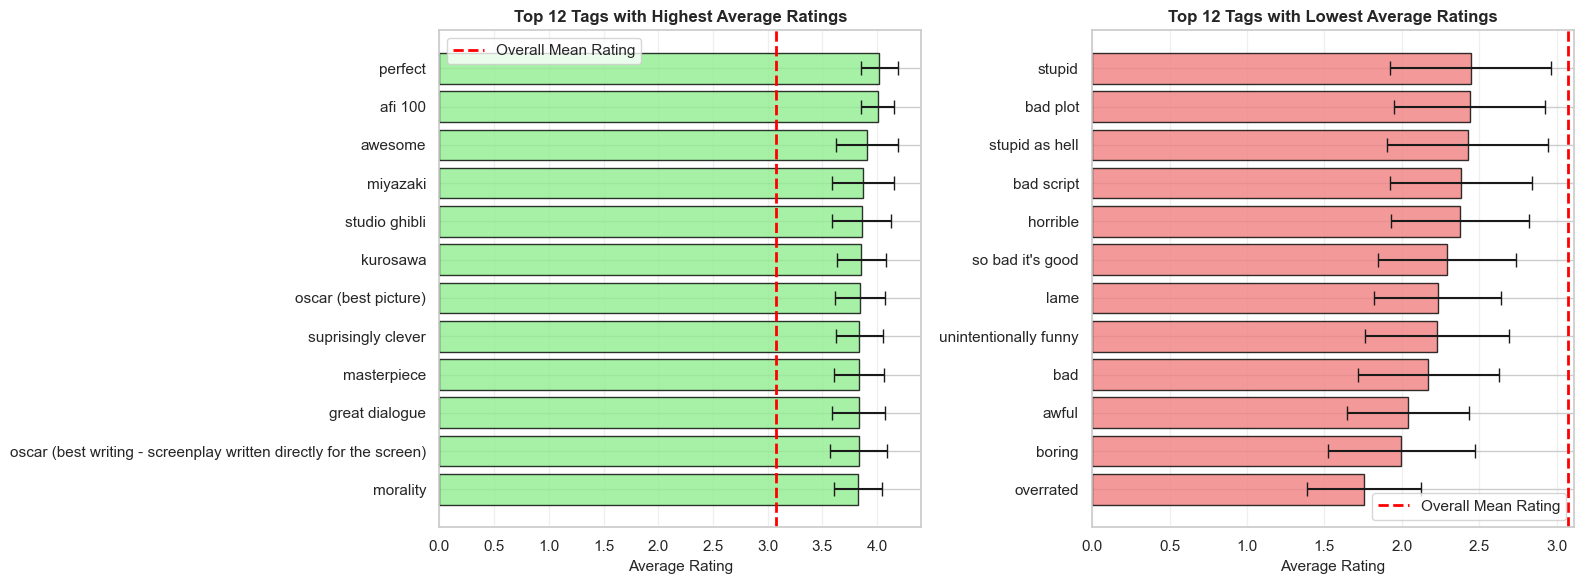

  - Error bars show standard deviation (rating variability within each tag)
  - Red line indicates overall average rating (3.07)
  - Tags above red line: associated with higher-rated movies
  - Tags below red line: associated with lower-rated movies


In [25]:
# Visualizations for Q7
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Top tags by average rating (highest)
top_tags_high = tag_ratings_sorted.head(12)
axes[0].barh(range(len(top_tags_high)), top_tags_high['mean_rating'], 
            xerr=top_tags_high['std_rating'], color='lightgreen', 
            edgecolor='black', capsize=5, alpha=0.8)
axes[0].set_yticks(range(len(top_tags_high)))
axes[0].set_yticklabels(top_tags_high.index)
axes[0].set_xlabel('Average Rating', fontsize=11)
axes[0].set_title('Top 12 Tags with Highest Average Ratings', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].axvline(movies_stats['avg_rating'].mean(), color='red', linestyle='--', 
               linewidth=2, label='Overall Mean Rating')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].legend()

# 2. Bottom tags by average rating (lowest)
bottom_tags_low = tag_ratings_sorted.tail(12)
axes[1].barh(range(len(bottom_tags_low)), bottom_tags_low['mean_rating'], 
            xerr=bottom_tags_low['std_rating'], color='lightcoral', 
            edgecolor='black', capsize=5, alpha=0.8)
axes[1].set_yticks(range(len(bottom_tags_low)))
axes[1].set_yticklabels(bottom_tags_low.index)
axes[1].set_xlabel('Average Rating', fontsize=11)
axes[1].set_title('Top 12 Tags with Lowest Average Ratings', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].axvline(movies_stats['avg_rating'].mean(), color='red', linestyle='--', 
               linewidth=2, label='Overall Mean Rating')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"  - Error bars show standard deviation (rating variability within each tag)")
print(f"  - Red line indicates overall average rating ({movies_stats['avg_rating'].mean():.2f})")
print(f"  - Tags above red line: associated with higher-rated movies")
print(f"  - Tags below red line: associated with lower-rated movies")

In [26]:
highest_tag = tag_ratings_sorted.index[0]
highest_rating = tag_ratings_sorted.iloc[0]['mean_rating']
lowest_tag = tag_ratings_sorted.index[-1]
lowest_rating = tag_ratings_sorted.iloc[-1]['mean_rating']
overall_mean = movies_stats['avg_rating'].mean()

print(f"\n• Highest-rated tags:")
print(f"  '{highest_tag}': {highest_rating:.3f} avg rating (+{highest_rating - overall_mean:.3f} above overall average)")

print(f"\n• Lowest-rated tags:")
print(f"  '{lowest_tag}': {lowest_rating:.3f} avg rating ({lowest_rating - overall_mean:.3f} below overall average)")

print(f"\n• Rating gap: {highest_rating - lowest_rating:.3f} points")

print(f"\n Key Insight:")
print(f"  → Content type significantly impacts ratings")
print(f"  → Certain genres/themes consistently attract higher-quality films")



• Highest-rated tags:
  'perfect': 4.021 avg rating (+0.949 above overall average)

• Lowest-rated tags:
  'overrated': 1.753 avg rating (-1.319 below overall average)

• Rating gap: 2.268 points

 Key Insight:
  → Content type significantly impacts ratings
  → Certain genres/themes consistently attract higher-quality films


#### Q8) Do certain genome tags significantly predict higher/lower ratings?


In [27]:
top_8_tags = tag_frequency.head(8).index.tolist()
print(f"\nTags being tested: {', '.join(top_8_tags)}")

tag_rating_groups = []
valid_tags = []

for tag in top_8_tags:
    tag_movies = genome_with_ratings[genome_with_ratings['tag'] == tag]['avg_rating'].dropna().values
    if len(tag_movies) > 1 and tag_movies.std() > 0:
        tag_rating_groups.append(tag_movies)
        valid_tags.append(tag)
        print(f"  {tag}: {len(tag_movies)} movies, mean={tag_movies.mean():.3f}, std={tag_movies.std():.3f}")
    else:
        print(f"  {tag}: SKIPPED (insufficient variance or data)")

if len(tag_rating_groups) >= 2:
    h_stat, p_value_kw = stats.kruskal(*tag_rating_groups)
    print(f"\nKruskal-Wallis Test ({len(valid_tags)} tags):")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  P-value: {p_value_kw:.6f}")
else:
    print(f"\n ERROR: Could not perform test—insufficient valid tags")



Tags being tested: original, mentor, great ending, runaway, good soundtrack, dialogue, storytelling, good
  original: 13728 movies, mean=3.271, std=0.484
  mentor: 7245 movies, mean=3.326, std=0.485
  great ending: 5001 movies, mean=3.444, std=0.452
  runaway: 4994 movies, mean=3.563, std=0.330
  good soundtrack: 4520 movies, mean=3.470, std=0.389
  dialogue: 4433 movies, mean=3.425, std=0.457
  storytelling: 4238 movies, mean=3.585, std=0.337
  good: 4215 movies, mean=3.454, std=0.373

Kruskal-Wallis Test (8 tags):
  H-statistic: 2812.7865
  P-value: 0.000000


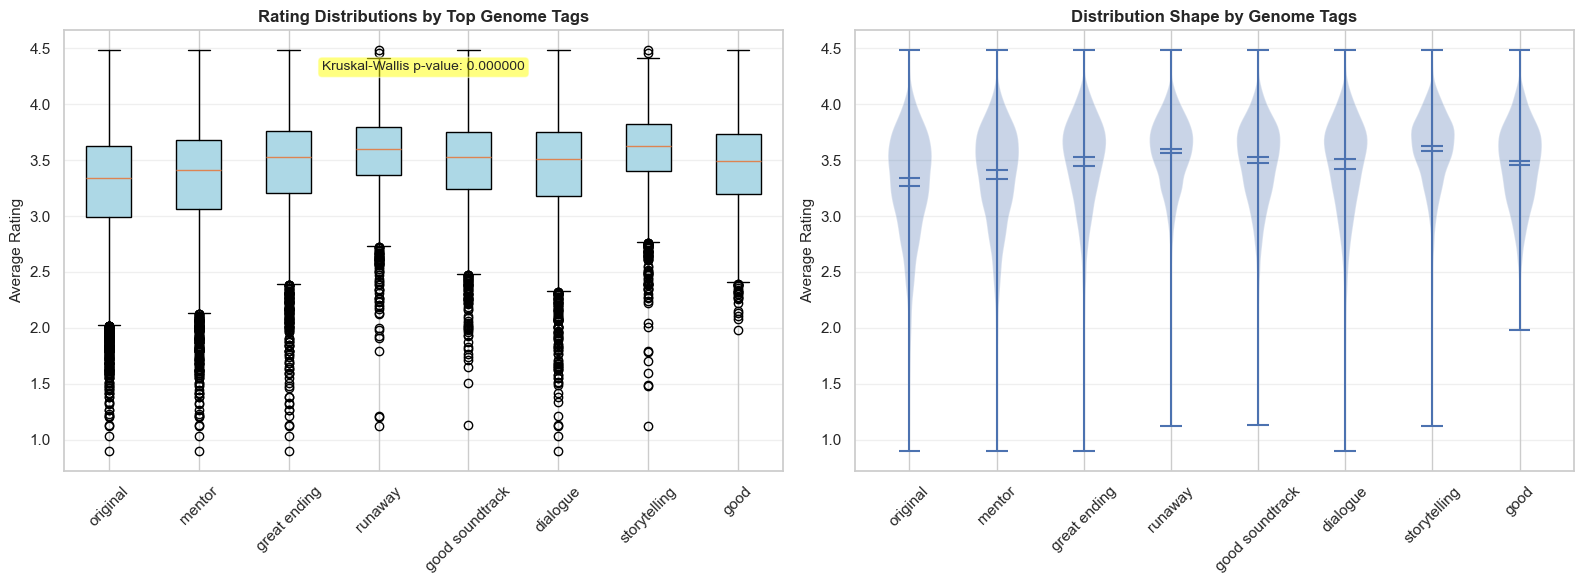

 - Box plot: Shows rating spread, median, quartiles for each tag group
 - Violin plot: Reveals shape/density differences between tag categories
 - Significant p-value means: Not all tags have the same rating profile—tag type correlates with audience ratings.


In [28]:
# Visualization for Q8
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of valid tags
bp = axes[0].boxplot(tag_rating_groups, labels=valid_tags, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

axes[0].set_ylabel('Average Rating', fontsize=11)
axes[0].set_title('Rating Distributions by Top Genome Tags', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].text(0.5, 0.93, f'Kruskal-Wallis p-value: {p_value_kw:.6f}', 
            transform=axes[0].transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5), ha='center')

# Violin plot for shape comparison
parts = axes[1].violinplot(tag_rating_groups, positions=range(len(valid_tags)), 
                          showmeans=True, showmedians=True)
axes[1].set_xticks(range(len(valid_tags)))
axes[1].set_xticklabels(valid_tags, rotation=45)
axes[1].set_ylabel('Average Rating', fontsize=11)
axes[1].set_title('Distribution Shape by Genome Tags', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(" - Box plot: Shows rating spread, median, quartiles for each tag group")
print(" - Violin plot: Reveals shape/density differences between tag categories")
print(f" - Significant p-value means: Not all tags have the same rating profile—tag type correlates with audience ratings.")


In [29]:
if len(tag_rating_groups) >= 2 and not np.isnan(p_value_kw):
    print(f"\n• Kruskal-Wallis Test Result for Most Frequent Tags:")
    print(f"  H-statistic: {h_stat:.2f}, P-value: {p_value_kw:.6f}")

    if p_value_kw < 0.05:
        print("\n Genome tags SIGNIFICANTLY predict movie ratings (p < 0.05)")
        print("   → Movie content type, by tag, is correlated with typical user ratings")
        print("   → Tags like 'runaway', 'storytelling', 'good soundtrack' differ in average rating from others")
        print("   → This insight can be leveraged for content recommendation and quality modeling.")
    else:
        print("\n NOT SIGNIFICANT: No strong evidence that popular tag categories differentiate movie quality (ratings are similar across frequent tags)")
else:
    print("\n Test not performed due to insufficient valid tag groups.")



• Kruskal-Wallis Test Result for Most Frequent Tags:
  H-statistic: 2812.79, P-value: 0.000000

 Genome tags SIGNIFICANTLY predict movie ratings (p < 0.05)
   → Movie content type, by tag, is correlated with typical user ratings
   → Tags like 'runaway', 'storytelling', 'good soundtrack' differ in average rating from others
   → This insight can be leveraged for content recommendation and quality modeling.


# User Tag Analysis

#### Note:

- During our data cleaning process we discovered that out of 58675 movies, only 41,731 movies (71.12%) have user tags while remaining 16,944 (28.88%) lack user tags.
- User tags are voluntary annotations by MovieLens users—not all users tag movies they rate. Some movies may have ratings but insufficient community interest to generate tags.
- Missing data represents movies that didn't inspire users to add descriptive tags (less memorable, niche, or older films). User tagging requires active engagement beyond just rating—a smaller, more invested user subset.
- Analysis focuses on movies with sufficient community engagement to attract tagging
- Missing data doesn't introduce bias—it reflects natural user behavior patterns
- Findings reflect user perception patterns for community-engaged films. Results are robust within this socially-annotated subset.

#### Q9) Which user tags appear most frequently in the dataset?

In [30]:
# Load user tag data from SQL
user_tags_query = """
SELECT
    "movieId",
    tag
FROM tags
"""

user_tags_df = pd.read_sql_query(user_tags_query, conn)

print(f"\nUser Tag Data Summary:")
print(f"  - Total user tag entries: {len(user_tags_df):,}")
print(f"  - Unique movies with user tags: {user_tags_df['movieId'].nunique():,}")
print(f"  - Unique user tags: {user_tags_df['tag'].nunique():,}")
print(f"  - Coverage: {100 * user_tags_df['movieId'].nunique() / len(movies_stats):.2f}% of all movies")

# Tag frequency analysis
user_tag_frequency = user_tags_df['tag'].value_counts()

print(f"\nTop 20 tags by frequency:")
print(user_tag_frequency.head(20))

print(f"\nTag frequency statistics:")
print(f"  - Most common tag: '{user_tag_frequency.index[0]}' ({user_tag_frequency.values[0]} times)")
print(f"  - Least common tag: '{user_tag_frequency.index[-1]}' ({user_tag_frequency.values[-1]} time)")
print(f"  - Median tag frequency: {user_tag_frequency.median():.0f}")
print(f"  - Mean tag frequency: {user_tag_frequency.mean():.2f}")



User Tag Data Summary:
  - Total user tag entries: 1,093,360
  - Unique movies with user tags: 45,251
  - Unique user tags: 73,050
  - Coverage: 77.12% of all movies

Top 20 tags by frequency:
tag
sci-fi                8330
atmospheric           6516
action                5907
comedy                5702
surreal               5326
based on a book       5079
twist ending          4820
funny                 4738
visually appealing    4526
dystopia              4257
dark comedy           4026
BD-R                  3966
thought-provoking     3844
romance               3791
stylized              3728
quirky                3677
psychology            3625
woman director        3589
fantasy               3523
classic               3456
Name: count, dtype: int64

Tag frequency statistics:
  - Most common tag: 'sci-fi' (8330 times)
  - Least common tag: 'cornetto triolgy' (1 time)
  - Median tag frequency: 2
  - Mean tag frequency: 14.97


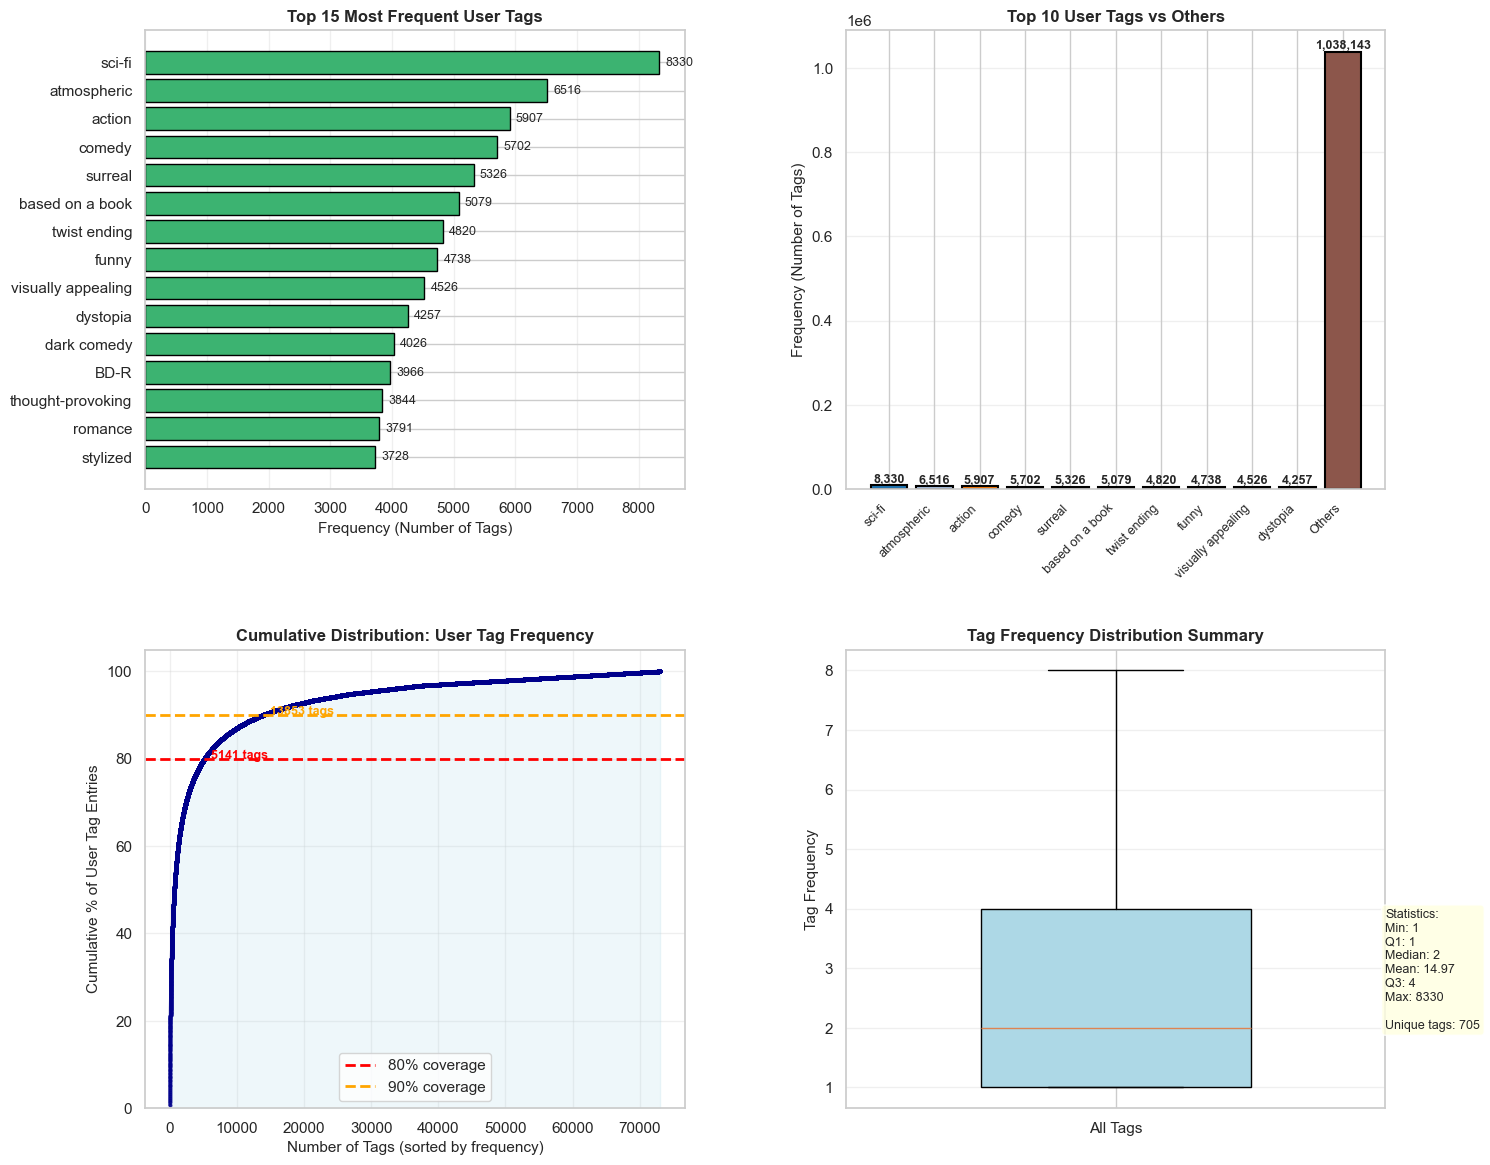

  - Chart 1: User tags show preference for broad descriptors (sci-fi, atmospheric, action)
  - Chart 2: Top 10 tags account for ~5.0% of all tags
  - Chart 3: Only 5141 tags needed for 80% coverage (extremely strong Pareto principle)
  - Chart 4: Median=2 but Mean=14.97 shows extreme long-tail: few popular tags, MANY one-off tags
    705 unique tags total


In [31]:
# Visualizations for Q9
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)  # Increased hspace for vertical spacing

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

# 1. Bar plot: Top 15 user tags
top_15_user_tags = user_tag_frequency.head(15)
axes[0].barh(range(len(top_15_user_tags)), top_15_user_tags.values, 
                color='mediumseagreen', edgecolor='black')
axes[0].set_yticks(range(len(top_15_user_tags)))
axes[0].set_yticklabels(top_15_user_tags.index)
axes[0].set_xlabel('Frequency (Number of Tags)', fontsize=11)
axes[0].set_title('Top 15 Most Frequent User Tags', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_15_user_tags.values):
    axes[0].text(v + 100, i, str(v), va='center', fontsize=9)

# 2. Stacked bar: Top 10 tags vs Others
top_10_user_tags = user_tag_frequency.head(10)
other_count = user_tag_frequency.iloc[10:].sum()

x_pos = range(len(top_10_user_tags) + 1)
values = list(top_10_user_tags.values) + [other_count]
labels = list(top_10_user_tags.index) + ['Others']

colors_bar = plt.cm.tab20(range(len(labels)))
bars = axes[1].bar(x_pos, values, color=colors_bar, edgecolor='black', linewidth=1.5)

axes[1].set_ylabel('Frequency (Number of Tags)', fontsize=11)
axes[1].set_title('Top 10 User Tags vs Others', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Cumulative distribution of user tag frequency
sorted_freq = sorted(user_tag_frequency.values, reverse=True)
cumsum = np.cumsum(sorted_freq)
cumsum_pct = 100 * cumsum / cumsum[-1]

axes[2].plot(range(len(sorted_freq)), cumsum_pct, linewidth=2.5, color='darkblue', 
               marker='o', markersize=2, alpha=0.7)
axes[2].fill_between(range(len(sorted_freq)), cumsum_pct, alpha=0.2, color='lightblue')
axes[2].axhline(80, color='red', linestyle='--', linewidth=2, label='80% coverage')
axes[2].axhline(90, color='orange', linestyle='--', linewidth=2, label='90% coverage')
axes[2].set_xlabel('Number of Tags (sorted by frequency)', fontsize=11)
axes[2].set_ylabel('Cumulative % of User Tag Entries', fontsize=11)
axes[2].set_title('Cumulative Distribution: User Tag Frequency', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_ylim([0, 105])

# Find tags for 80% and 90% coverage
tags_for_80 = np.argmax(cumsum_pct >= 80) + 1
tags_for_90 = np.argmax(cumsum_pct >= 90) + 1

axes[2].text(tags_for_80, 80, f'  {tags_for_80} tags', fontsize=9, color='red', fontweight='bold')
axes[2].text(tags_for_90, 90, f'  {tags_for_90} tags', fontsize=9, color='orange', fontweight='bold')

# 4. Box plot showing tag frequency distribution statistics
freq_stats = {
    'Min': user_tag_frequency.min(),
    'Q1': user_tag_frequency.quantile(0.25),
    'Median': user_tag_frequency.median(),
    'Mean': user_tag_frequency.mean(),
    'Q3': user_tag_frequency.quantile(0.75),
    'Max': user_tag_frequency.max()
}

bp = axes[3].boxplot([user_tag_frequency.values], labels=['All Tags'], patch_artist=True, 
                        widths=0.5, showfliers=False)
bp['boxes'][0].set_facecolor('lightblue')

axes[3].set_ylabel('Tag Frequency', fontsize=11)
axes[3].set_title('Tag Frequency Distribution Summary', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3, axis='y')

# Add statistics text on the side
stats_text = f"""Statistics:
Min: {freq_stats['Min']:.0f}
Q1: {freq_stats['Q1']:.0f}
Median: {freq_stats['Median']:.0f}
Mean: {freq_stats['Mean']:.2f}
Q3: {freq_stats['Q3']:.0f}
Max: {freq_stats['Max']:.0f}

Unique tags: {user_tag_frequency.nunique():,}"""

axes[3].text(1.5, freq_stats['Q3'], stats_text, fontsize=9, 
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
               verticalalignment='top')

plt.show()

print(f"  - Chart 1: User tags show preference for broad descriptors (sci-fi, atmospheric, action)")
print(f"  - Chart 2: Top 10 tags account for ~{sum(top_10_user_tags.values) / user_tag_frequency.sum() * 100:.1f}% of all tags")
print(f"  - Chart 3: Only {tags_for_80} tags needed for 80% coverage (extremely strong Pareto principle)")
print(f"  - Chart 4: Median=2 but Mean=14.97 shows extreme long-tail: few popular tags, MANY one-off tags")
print(f"    {user_tag_frequency.nunique():,} unique tags total")


In [32]:
print(f"\nTop 10 user tags by frequency:")
for i, (tag, count) in enumerate(user_tag_frequency.head(10).items(), 1):
    pct_of_tagged = 100 * count / len(user_tags_df)
    print(f"  {i}. '{tag}': {count:,} times ({pct_of_tagged:.1f}% of all user tags)")

print(f"\n Key Insights:")
print(f"  → User tags capture what audiences find memorable or noteworthy")
print(f"  → Broad, mainstream descriptors dominate ('{user_tag_frequency.index[0]}', '{user_tag_frequency.index[1]}', '{user_tag_frequency.index[2]}')")
print(f"  → {user_tag_frequency.nunique():,} unique tags show long-tail behavior")
print(f"  → Most tags are niche or one-off annotations by engaged users")


Top 10 user tags by frequency:
  1. 'sci-fi': 8,330 times (0.8% of all user tags)
  2. 'atmospheric': 6,516 times (0.6% of all user tags)
  3. 'action': 5,907 times (0.5% of all user tags)
  4. 'comedy': 5,702 times (0.5% of all user tags)
  5. 'surreal': 5,326 times (0.5% of all user tags)
  6. 'based on a book': 5,079 times (0.5% of all user tags)
  7. 'twist ending': 4,820 times (0.4% of all user tags)
  8. 'funny': 4,738 times (0.4% of all user tags)
  9. 'visually appealing': 4,526 times (0.4% of all user tags)
  10. 'dystopia': 4,257 times (0.4% of all user tags)

 Key Insights:
  → User tags capture what audiences find memorable or noteworthy
  → Broad, mainstream descriptors dominate ('sci-fi', 'atmospheric', 'action')
  → 705 unique tags show long-tail behavior
  → Most tags are niche or one-off annotations by engaged users


#### Q10) How do user-tagged movies compare to non-tagged movies in ratings?

In [33]:
# Get movies with and without user tags
tagged_movies_set = set(user_tags_df['movieId'].unique())
movies_with_tags = movies_stats[movies_stats['movieId'].isin(tagged_movies_set)]
movies_without_tags = movies_stats[~movies_stats['movieId'].isin(tagged_movies_set)]

print(f"\nMovies WITH user tags:")
print(f"  - Count: {len(movies_with_tags):,}")
print(f"  - Mean rating: {movies_with_tags['avg_rating'].mean():.3f}")
print(f"  - Median rating: {movies_with_tags['avg_rating'].median():.3f}")
print(f"  - Std Dev: {movies_with_tags['avg_rating'].std():.3f}")
print(f"  - Mean rating count: {movies_with_tags['rating_count'].mean():.0f}")

print(f"\nMovies WITHOUT user tags:")
print(f"  - Count: {len(movies_without_tags):,}")
print(f"  - Mean rating: {movies_without_tags['avg_rating'].mean():.3f}")
print(f"  - Median rating: {movies_without_tags['avg_rating'].median():.3f}")
print(f"  - Std Dev: {movies_without_tags['avg_rating'].std():.3f}")
print(f"  - Mean rating count: {movies_without_tags['rating_count'].mean():.0f}")

# Mann-Whitney U test
u_stat_tags, p_value_tags = stats.mannwhitneyu(movies_with_tags['avg_rating'], 
                                               movies_without_tags['avg_rating'], 
                                               alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_stat_tags:.2f}")
print(f"  P-value: {p_value_tags:.6f}")

if p_value_tags < 0.05:
    diff = movies_with_tags['avg_rating'].mean() - movies_without_tags['avg_rating'].mean()
    direction = "HIGHER" if diff > 0 else "LOWER"
    print(f"\n SIGNIFICANT: Tagged movies rated {direction} ({abs(diff):.3f} points difference, p < 0.05)")
else:
    print(f"\n NOT SIGNIFICANT: No meaningful difference in ratings between tagged and non-tagged movies")



Movies WITH user tags:
  - Count: 41,731
  - Mean rating: 3.110
  - Median rating: 3.190
  - Std Dev: 0.653
  - Mean rating count: 597

Movies WITHOUT user tags:
  - Count: 16,944
  - Mean rating: 2.976
  - Median rating: 3.000
  - Std Dev: 0.905
  - Mean rating count: 5

Mann-Whitney U Test:
  U-statistic: 387023680.00
  P-value: 0.000000

 SIGNIFICANT: Tagged movies rated HIGHER (0.135 points difference, p < 0.05)


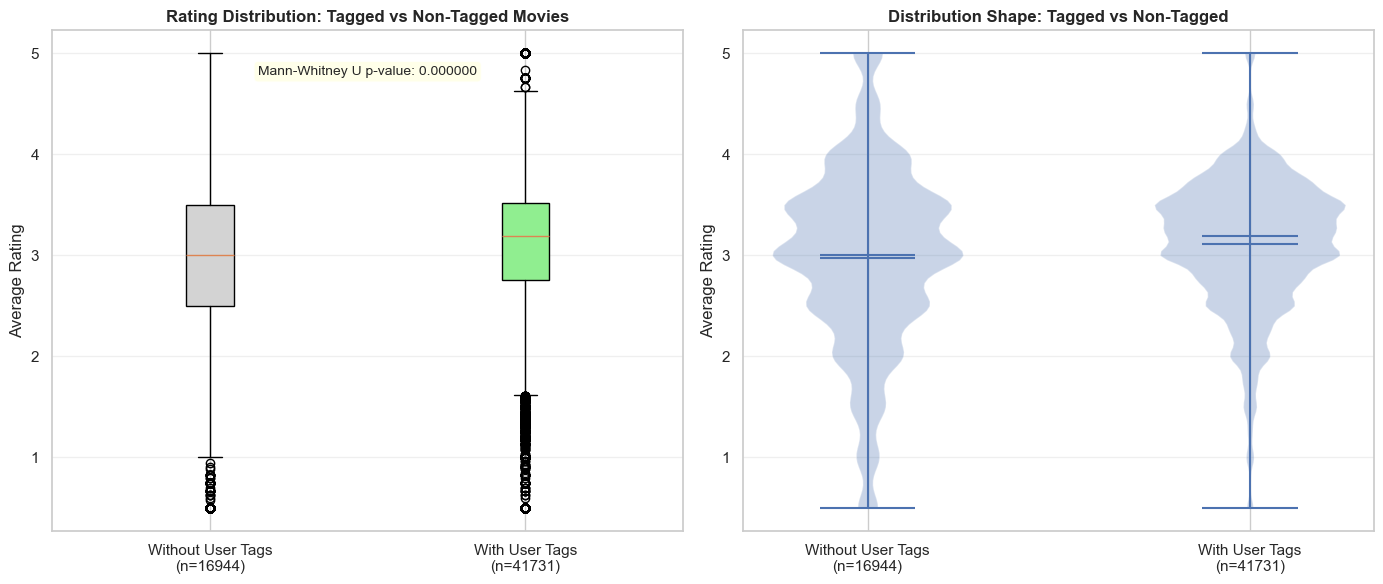

  - Box plot: Shows median, quartiles for each group
  - Violin plot: Reveals distribution shape differences
  - User tagging likely correlates with movie engagement and quality


In [34]:
# Visualizations for Q10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot comparison
data_for_boxplot = [movies_without_tags['avg_rating'].values, movies_with_tags['avg_rating'].values]
bp = axes[0].boxplot(data_for_boxplot, 
                     labels=['Without User Tags\n(n=' + str(len(movies_without_tags)) + ')', 
                            'With User Tags\n(n=' + str(len(movies_with_tags)) + ')'],
                     patch_artist=True)

colors = ['lightgray', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes[0].set_title('Rating Distribution: Tagged vs Non-Tagged Movies', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Rating')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].text(0.5, 0.93, f'Mann-Whitney U p-value: {p_value_tags:.6f}', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
            ha='center')

# Violin plot comparison
parts = axes[1].violinplot([movies_without_tags['avg_rating'].values, movies_with_tags['avg_rating'].values],
                          positions=[1, 2], showmeans=True, showmedians=True)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Without User Tags\n(n=' + str(len(movies_without_tags)) + ')', 
                        'With User Tags\n(n=' + str(len(movies_with_tags)) + ')'])
axes[1].set_title('Distribution Shape: Tagged vs Non-Tagged', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rating')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("  - Box plot: Shows median, quartiles for each group")
print("  - Violin plot: Reveals distribution shape differences")
print("  - User tagging likely correlates with movie engagement and quality")

In [35]:
tagged_mean = movies_with_tags['avg_rating'].mean()
untagged_mean = movies_without_tags['avg_rating'].mean()
diff_rating = tagged_mean - untagged_mean

print(f"\n• Movies WITH user tags (n={len(movies_with_tags):,}):")
print(f"  Mean rating: {tagged_mean:.3f}, Median: {movies_with_tags['avg_rating'].median():.3f}")

print(f"\n• Movies WITHOUT user tags (n={len(movies_without_tags):,}):")
print(f"  Mean rating: {untagged_mean:.3f}, Median: {movies_without_tags['avg_rating'].median():.3f}")

print(f"\n• Rating Difference: {diff_rating:.3f} points (Mann-Whitney U: p {f'< 0.001' if p_value_tags < 0.001 else f'= {p_value_tags:.3f}'})")

if p_value_tags < 0.05:
    print(f"\n User-tagged movies are significantly {'higher' if diff_rating > 0 else 'lower'}-rated")
    print(f"   → Community engagement (tagging) correlates with perceived quality")
    print(f"   → Tagged movies represent films worth discussing and annotating")
else:
    print(f"\n No significant difference—users tag across all rating ranges")


• Movies WITH user tags (n=41,731):
  Mean rating: 3.110, Median: 3.190

• Movies WITHOUT user tags (n=16,944):
  Mean rating: 2.976, Median: 3.000

• Rating Difference: 0.135 points (Mann-Whitney U: p < 0.001)

 User-tagged movies are significantly higher-rated
   → Community engagement (tagging) correlates with perceived quality
   → Tagged movies represent films worth discussing and annotating


#### Q11) Which user tags are associated with highest/lowest average ratings?

In [36]:
# Join user tags with ratings
user_tags_with_ratings = user_tags_df.merge(movies_stats[['movieId', 'avg_rating']], 
                                            on='movieId', how='left')

# Calculate statistics by tag
tag_rating_stats = user_tags_with_ratings.groupby('tag').agg({
    'avg_rating': ['mean', 'median', 'std', 'count'],
    'movieId': 'nunique'
}).round(3)

tag_rating_stats.columns = ['mean_rating', 'median_rating', 'std_rating', 'tag_count', 'num_movies']

# Filter tags appearing at least 20 times (sufficient sample)
tag_rating_stats_filtered = tag_rating_stats[tag_rating_stats['num_movies'] >= 20]
tag_rating_stats_sorted = tag_rating_stats_filtered.sort_values('mean_rating', ascending=False)

print("\n--- Top 10 User Tags with HIGHEST Average Ratings ---")
print("(Filtered: tags on ≥20 movies)")
print(tag_rating_stats_sorted[['mean_rating', 'median_rating', 'std_rating', 'num_movies']].head(10))

print("\n--- Top 10 User Tags with LOWEST Average Ratings ---")
print(tag_rating_stats_sorted[['mean_rating', 'median_rating', 'std_rating', 'num_movies']].tail(10))



--- Top 10 User Tags with HIGHEST Average Ratings ---
(Filtered: tags on ≥20 movies)
                     mean_rating  median_rating  std_rating  num_movies
tag                                                                    
masterpiece                 4.09           4.09        0.18          57
top 250 IMDB                4.07           4.10        0.11          51
Studio Ghibli               4.05           4.09        0.18          22
imdb top 250                4.04           4.05        0.15         322
Mafia                       4.04           4.18        0.36          36
excellent script            4.03           4.07        0.18          24
complicated                 4.03           4.15        0.23          30
prison escape               4.02           4.10        0.49          53
Humphrey Bogart             4.02           4.13        0.28          24
100 Greatest Movies         4.02           4.09        0.20          51

--- Top 10 User Tags with LOWEST Average Ratings 

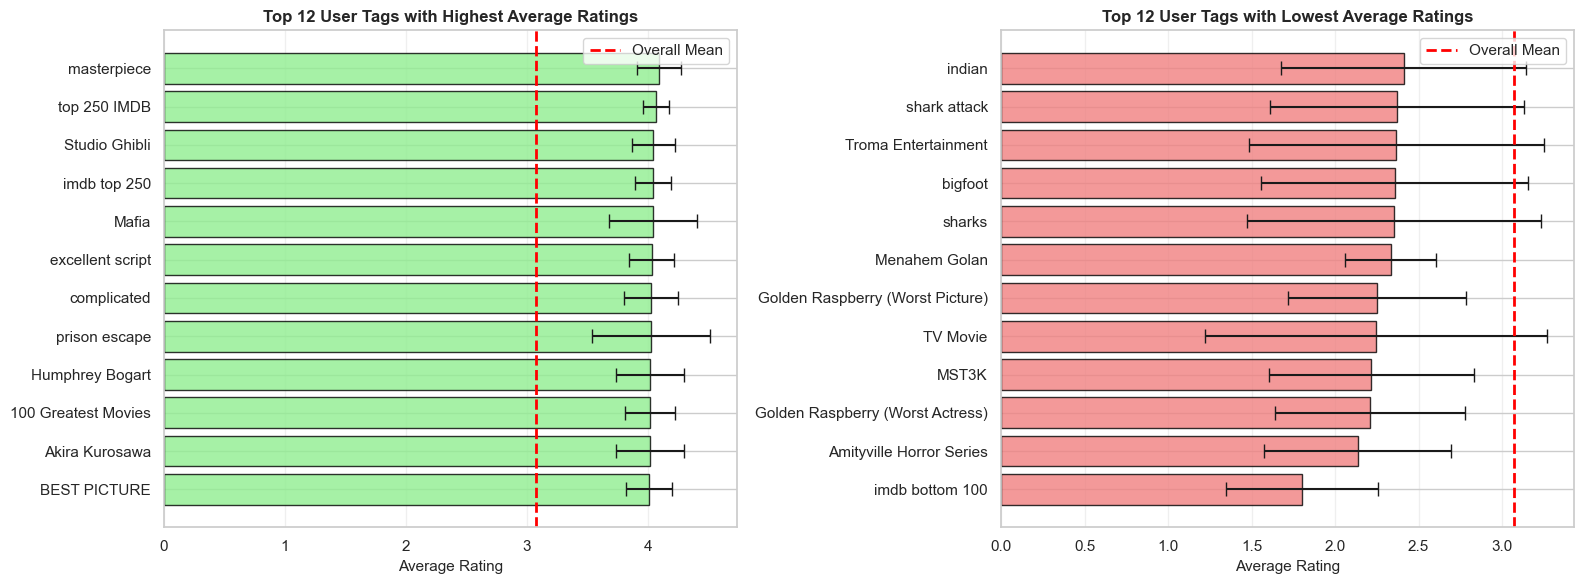

  - Error bars show standard deviation (rating spread within each tag)
  - Red line = overall average rating (3.07)
  - Tags above line: attract higher-rated movies
  - Tags below line: often applied to lower-rated films


In [37]:
# Visualizations for Q11
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Top tags by average rating (highest)
top_tags_high = tag_rating_stats_sorted.head(12)
axes[0].barh(range(len(top_tags_high)), top_tags_high['mean_rating'], 
            xerr=top_tags_high['std_rating'], color='lightgreen', 
            edgecolor='black', capsize=5, alpha=0.8)
axes[0].set_yticks(range(len(top_tags_high)))
axes[0].set_yticklabels(top_tags_high.index)
axes[0].set_xlabel('Average Rating', fontsize=11)
axes[0].set_title('Top 12 User Tags with Highest Average Ratings', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].axvline(movies_stats['avg_rating'].mean(), color='red', linestyle='--', 
               linewidth=2, label='Overall Mean')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].legend()

# 2. Bottom tags by average rating (lowest)
bottom_tags_low = tag_rating_stats_sorted.tail(12)
axes[1].barh(range(len(bottom_tags_low)), bottom_tags_low['mean_rating'], 
            xerr=bottom_tags_low['std_rating'], color='lightcoral', 
            edgecolor='black', capsize=5, alpha=0.8)
axes[1].set_yticks(range(len(bottom_tags_low)))
axes[1].set_yticklabels(bottom_tags_low.index)
axes[1].set_xlabel('Average Rating', fontsize=11)
axes[1].set_title('Top 12 User Tags with Lowest Average Ratings', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].axvline(movies_stats['avg_rating'].mean(), color='red', linestyle='--', 
               linewidth=2, label='Overall Mean')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"  - Error bars show standard deviation (rating spread within each tag)")
print(f"  - Red line = overall average rating ({movies_stats['avg_rating'].mean():.2f})")
print(f"  - Tags above line: attract higher-rated movies")
print(f"  - Tags below line: often applied to lower-rated films")

In [38]:
highest_tag = tag_rating_stats_sorted.index[0]
highest_rating = tag_rating_stats_sorted.iloc[0]['mean_rating']
lowest_tag = tag_rating_stats_sorted.index[-1]
lowest_rating = tag_rating_stats_sorted.iloc[-1]['mean_rating']
overall_mean = movies_stats['avg_rating'].mean()

print(f"\n• Highest-rated user tags:")
print(f"  '{highest_tag}': {highest_rating:.3f} avg rating (+{highest_rating - overall_mean:.3f} above average)")

print(f"\n• Lowest-rated user tags:")
print(f"  '{lowest_tag}': {lowest_rating:.3f} avg rating ({lowest_rating - overall_mean:.3f} below average)")

print(f"\n• Rating gap: {highest_rating - lowest_rating:.3f} points")

print(f"\n Key Insight:")
print(f"  → User tag preferences reveal quality perception patterns")
print(f"  → Some descriptors cluster on acclaimed films, others on lower-rated content")
print(f"  → User tagging behavior is a proxy for film reception and engagement")



• Highest-rated user tags:
  'masterpiece': 4.090 avg rating (+1.018 above average)

• Lowest-rated user tags:
  'imdb bottom 100': 1.801 avg rating (-1.271 below average)

• Rating gap: 2.289 points

 Key Insight:
  → User tag preferences reveal quality perception patterns
  → Some descriptors cluster on acclaimed films, others on lower-rated content
  → User tagging behavior is a proxy for film reception and engagement
